# MDMRT scan project data analysis

## Set up functions to run DTB fits and plot data with fits

In [1]:
# load all necessary packages
%load_ext rpy2.ipython
%R library(lme4)
%R library(sjPlot)
%R library(ggplot2)

#%load_ext pymatbridge
from __future__ import division
from __future__ import print_function
from scipy.stats import norm
from scipy.signal import fftconvolve
import matplotlib.gridspec as gridspec
import brewer2mpl as b2mpl
import fminbnd
import os, glob, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nilearn
from nilearn import image
from nilearn import plotting
import multiprocessing  
from joblib import Parallel, delayed
import pickle


# list of subject IDs
subjid=list(range(2,26))+list(range(27,32))+[33]

# path to data
datapath='/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Output/'

# Functions
logitinv = lambda x: np.exp(x)/(1.0+np.exp(x))
flogit = lambda x,k,c0,B: logitinv(2*k*(x+c0)*B)
fRT = lambda x,k,c0,B,t0: (B/(k*(x+c0)))*np.tanh(k*(x+c0)*B) + t0

eps = 2 ** -52

# a few global variables that speed up optimization
T = None
It = None
STIM_STRENGTH = None
Ic = None

sns.set_style('ticks')
sns.set_context('talk')


/Users/akram/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Learn more about sjPlot with 'browseVignettes("sjPlot")'.

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def fitData(
        data, dt=.0005, k=5, B0=1.5, Bdel=1, B2=1,
        tnd=0.5, tnd_sd=0.05, stim_strength_bias=0, y0=0, plaw=1):

    """
    Fit choices and reaction times to a diffusion to bound model
    with exponentially and symmetrically decreasing bounds

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is number of trials
          and the columns correspond to stim_strength, rt, and choice

    dt : temporal resolution of the simulated diffusion process

    ########## The following are initial values of parameters ##############

    k : float, proportionality constant between stim_strength and drift rate

    B0 : float, initial bound height

    Bdelay : float, delay in seconds before bound starts decreasing

    B2 : float, coefficient of exponential term that governs bound decrease

    tnd: float, non decision time

    tnd_sd: float, standard deviation of non-decision time

    stim_strength_bias : bias in drift rate (added to stim_strength before k mult)

    y0 : initial offset of decision variable (relative to 0)
    
    plaw : power law coefficient for stim_strengths


    Returns
    -------
    theta : 1D array of 9 params -
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    """

    global T, It, STIM_STRENGTH, Ic
    T, It, STIM_STRENGTH, Ic = None, None, None, None

    stim_strengths = data[:, 0]
    rt = data[:, 1]
    ci = data[:, 2]

    # plausible bounds for the parameters
    theta_lo = [0.2, 0.5,  0,  0, 0.3 , 0 ,-0.2,  0, 1/20]
    theta_hi = [35,  4,    5,  3, 1   , 0.1  ,0.2, 0, 3]
    theta_init = [k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw]

    theta, fopt = fminbnd.fminbnd(
        calculateNegLL, theta_init, args=(stim_strengths, rt, ci, dt),
        LB=theta_lo, UB=theta_hi)

    # clear the globals
    T, It, STIM_STRENGTH, Ic = None, None, None, None

    return theta, fopt

In [3]:
def plotDotsDataWithFit(data, theta, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, subj = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    meanprop = sortedFunc(ci, stim_strengths, 'mean')[:, 1]
    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','subj'])  
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    # calculate participant means per subject
    smean = df.groupby(['subj','stim_strength'],as_index=False).mean()
    # SEM across participant means
    semprop = smean.groupby('stim_strength').sem()['ci']
    
    # predicted proportions
    predprop = D['up']['p'][:]

    #chose blue or chose yellow
    cb=df[df['ci']==1]
    cy=df[df['ci']==0]
    
    #means per participant per stim_strenght
    scbmeans=cb.groupby(['subj','stim_strength'],as_index=False).mean()
    scymeans=cy.groupby(['subj','stim_strength'],as_index=False).mean()
    bothmeans=df.groupby(['subj','stim_strength'],as_index=False).mean()
    del scymeans['ci'] 
    del scbmeans['ci'] 
    del bothmeans['ci']     
    
    meanrt_lo=cy.groupby(['stim_strength'],as_index=False).mean()['rt']
    meanrt_up=cb.groupby(['stim_strength'],as_index=False).mean()['rt']
    meanrt_both=df.groupby(['stim_strength'],as_index=False).mean()['rt']
    
    semrt_lo=scymeans.groupby('stim_strength').sem()['rt']
    semrt_up=scbmeans.groupby('stim_strength').sem()['rt']
    semrt_both=df.groupby('stim_strength').sem()['rt']
    

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.errorbar(ustim_strengths, meanprop, yerr=semprop, color='grey',
                       linestyle='None', capsize=0, marker='o')
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_choice.set_ylabel('P(respond Blue)')

    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.errorbar(ustim_strengths, meanrt_both, yerr=semrt_both,
                   color='grey', linestyle='None', marker='o', capsize=0)
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.show()

In [4]:
def plotDotsubDataWithFit(data, theta, subjid, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci = data[:, 0], data[:, 1], data[:, 2]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths) 
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    meanprop = sortedFunc(ci, stim_strengths, 'mean')[:, 1]
    df=pd.DataFrame(data,columns=['stim_strength','rt','ci'])
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    
    # calculate stdev per stim strengh
    semprop = df.groupby(['stim_strength']).sem()['ci']
    
    # predicted proportions
    predprop = D['up']['p'][:]

    #chose blue or chose yellow
    cb=df[df['ci']==1]
    cy=df[df['ci']==0]
    
    meanrt_lo=cy.groupby(['stim_strength']).mean()['rt']
    meanrt_up=cb.groupby(['stim_strength']).mean()['rt']
    meanrt_both=df.groupby(['stim_strength']).mean()['rt']
    
    del cb['ci']
    del cy['ci']
    
    semrt_lo=cy.groupby(['stim_strength']).sem()['rt']
    semrt_up=cb.groupby(['stim_strength']).sem()['rt']
    semrt_both=df.groupby(['stim_strength']).sem()['rt']
    

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.errorbar(ustim_strengths, meanprop, yerr=semprop, color='grey',
                       linestyle='None', capsize=0, marker='o')
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_choice.set_ylabel('P(respond Blue)')
    
    plt.title('Perceptual choices for participant ' + subjid)
    
    ax_rt = fig.add_subplot(1, 2, 2)
    ustim_strengths=np.array(meanrt_both.index)
    ax_rt.errorbar(ustim_strengths, meanrt_both, yerr=semrt_both,
                   color='grey', linestyle='None', marker='o', capsize=0)
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.title('Perceptual RT for participant ' + subjid)
    plt.show()
    

In [5]:
def plotFoodDataWithFit(data, theta, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, subj = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','subj','deltaval'])  
    #df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    
    dfsorted=df.sort_values('deltaval', ascending=True)
    
    #running mean of choices
    meanprop = pd.Series.rolling(dfsorted['ci'],100,min_periods=50).mean()

    # predicted proportions
    predprop = D['up']['p'][:]

    #chose right or chose left
    cr=dfsorted[dfsorted['ci']==1]
    cl=dfsorted[dfsorted['ci']==0]
    
    #running mean of rt
    meanrt_lo = pd.Series.rolling(cl['rt'],50,min_periods=25).mean()
    meanrt_up = pd.Series.rolling(cr['rt'],50,min_periods=25).mean()
    meanrt_both = pd.Series.rolling(dfsorted['rt'],100,min_periods=50).mean()

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.add_line(
        plt.Line2D(dfsorted['deltaval'], meanprop, color='grey'))
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('DeltaValue (Right - Left)')
    ax_choice.set_ylabel('P(respond Right)')

    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.add_line(
        plt.Line2D(dfsorted['deltaval'], meanrt_both, color='grey'))
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.show()

In [6]:
def plotFoodsubDataWithFit(data, theta, subjid, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    subjid : subject id

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, deltaval = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    
    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','deltaval'])  
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    
    dfsorted=df.sort_values('deltaval', ascending=True)
    
    #running mean of choices
    meanprop = pd.Series.rolling(dfsorted['ci'],10,min_periods=2).mean()

    # predicted proportions
    predprop = D['up']['p'][:]

    #chose right or chose left
    cr=dfsorted[dfsorted['ci']==1]
    cl=dfsorted[dfsorted['ci']==0]
    
   
    #running mean of rt
    meanrt_lo = pd.Series.rolling(cl['rt'],10,min_periods=2).mean()
    meanrt_up = pd.Series.rolling(cr['rt'],10,min_periods=2).mean()
    meanrt_both = pd.Series.rolling(dfsorted['rt'],10,min_periods=2).mean()

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both=D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.add_line(
        plt.Line2D(dfsorted['deltaval'], meanprop, color='grey'))
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('DeltaValue (Right - Left)')
    ax_choice.set_ylabel('P(respond Right)')
    plt.title('Value-based choice for participant ' + subjid)
    
    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.add_line(
        plt.Line2D(dfsorted['deltaval'], meanrt_both, color='grey'))
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.title('Value-based RT for participant ' + subjid)
    plt.show()

In [7]:
def calculateNegLL(theta, stim_strengths, rt, ci, dt=0.0005):
    """
    Given a  diffusion to bound model with quadratically collapsing bounds
    parametrized by theta, compute the negative log likelihood of the data

    Parameters
    ----------
    theta : 8 element list or array containing the DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0

    stim_strengths : array of stimulus strengths, length equal to # trials

    rt : array of reaction times, length equal to # trials

    ci : array of choices (0, 1: 1 is correct choice for positive
         stim_strengths), length equal to # trials

    dt : float, temporal resolution, in seconds, to use when propagating

    Returns
    -------
    neglogll : float, negative log likelihood of the data

    """

    global T, It, STIM_STRENGTH, Ic

    # unpack parameters
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    
    stim_strengths = stim_strengths.astype("complex") ** plaw
    u_stim_strengths = np.unique(stim_strengths)

    # propagate expects drift to be 2d so that it can tile properly
    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, u_stim_strengths, np.max(rt), dt)

    # propagate density
    D = propagate(drifts, t, Bup, Blo, y, yinit)

    # convolve distribution of exit times with Gaussian distribution of tnd
    r = norm.pdf(t, tnd, tnd_sd) * dt
    P_UP = np.zeros([D['up']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['up']['pdf_t'].shape[1]])
    P_LO = np.zeros([D['lo']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['up']['pdf_t'].shape[1]])
    P_BOTH = np.zeros([D['both']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['both']['pdf_t'].shape[1]])
    for i in xrange(len(u_stim_strengths)):
        P_UP[:, i] = fftconvolve(D['up']['pdf_t'][:, i], r.flatten())
        P_LO[:, i] = fftconvolve(D['lo']['pdf_t'][:, i], r.flatten())
        P_BOTH[:, i] = fftconvolve(D['both']['pdf_t'][:, i], r.flatten())

    if T is None:
        # find time index of each trial
        T = np.tile(t, [1, len(rt)])
        It = np.sum(~(T >= rt), axis=0) - 1

        # find stim_strength index of each trial
        C = np.tile(np.atleast_2d(u_stim_strengths), [len(stim_strengths), 1])
        Ic = np.sum(C <= np.atleast_2d(stim_strengths).T, axis=1) - 1

    p_up = P_UP[It, Ic]
    p_lo = P_LO[It, Ic]
    p_both = P_BOTH[It, Ic]
    p_up = np.clip(p_up, eps, 1 - eps)
    p_lo = np.clip(p_lo, eps, 1 - eps)
    p_both = np.clip(p_both, eps, 1 - eps)

    ppred = p_up * ci + p_lo * np.logical_not(ci)
    #ppred = p_both
    neglogl = -np.sum(np.log(ppred))

    return neglogl

In [8]:
def propagate(drifts, t, Bup, Blo, y, y0, notabs_flag=False):
    """
    Given a set of drift rates and bounds, compute various quantities
    that characterize the behavior of the drift-diffusion process

    Parameters
    ----------
    drifts : 2D array of shape (1, nd) where nd is the number of drift rates;
             this is a row vector of drifts

    t : 2D array of shape (nt, 1) where nt is the number of time points;
        this is a column vector of time points

    Bup : 2D array of shape (nt, 1) where nt is the number of time points;
          this is a column vector of upper bounds, one value per each time bin

    Blo : 2D array of shape (nt, 1) where nt is the number of time points;
          this is a column vector of lower bounds, one value per each time bin

    y : 2D array of shape (ng, 1) where ng is the number of grid points
        over which to compute Gaussian density; this is a column vector
        of grid points to which y0 corresponds

    y0 : 2D array of shape (ng, 1) where ng is the number of grid points
         over which to compute Gaussian density; this is a column vector
         of actual initial density values

    notabs_flag : boolean, whether to store the not absorbed portion of density

    Returns
    -------
    D : dictionary, contains for each unique stimulus strengh the probability
        of hitting the upper or lower bound, the mean reaction times for the
        two bounds, and the cumulative distribution of reaction times for the
        two bounds (and the not absored densities if requested)

    """
    
    nd = drifts.shape[1]
    nt = t.shape[0]
    dt = t[1, 0] - t[0, 0]
    ny = y.shape[0]

    D = {}
    D['bounds'] = np.column_stack([Bup, Blo])
    D['drifts'] = drifts

    # create fft of zero mean, unit variance gaussian
    kk = np.tile(np.atleast_2d(np.concatenate(
        [np.arange(0, ny / 2 + 1), np.arange(-ny / 2 + 1, 0)])).T, [1, nd])
    omega = 2 * np.pi * kk / (np.max(y) - np.min(y))
    E1 = np.exp(-0.5 * dt * np.power(omega, 2))
    D['up'] = {}
    D['lo'] = {}
    D['both'] = {}
    if notabs_flag:
        D['notabs'] = {}

    D['up']['pdf_t'] = np.zeros([nt, nd])
    D['lo']['pdf_t'] = np.zeros([nt, nd])
    D['both']['pdf_t'] = np.zeros([nt, nd])
    if notabs_flag:
        D['notabs']['pdf'] = np.zeros([nd, ny, nt])

    # U is initial state, one column for each drift rate
    U = np.tile(y0, [1, nd])

    # shift mean of zero mean, unit variance gaussian by drift
    E2 = E1 * np.exp(-1j * omega * np.tile(drifts, [ny, 1]) * dt)

    # prepare the values to propagate for vectorization
    y = np.tile(y, [1, nd])
    p_threshold = .00001
    for i in range(nt):
        # fft current pdf
        Ufft = np.fft.fft(U, axis=0)

        # convolve with gaussian with drift in the frequency domain
        Ufft = E2 * Ufft

        # turn back into time domain
        U = np.real(np.fft.ifft(Ufft, axis=0))
        U = np.clip(U, 0, np.inf)

        D['up']['pdf_t'][i, :] = np.sum(U * (y >= Bup[i]), axis=0)
        D['lo']['pdf_t'][i, :] = np.sum(U * (y <= Blo[i]), axis=0)
        D['both']['pdf_t'][i, :] = np.sum(U * ((y <= Blo[i]) | (y >= Bup[i])), axis=0)

        # keep only density within bounds
        U *= np.logical_and(y > Blo[i], y < Bup[i])

        # store not absorbed density if requested
        if notabs_flag:
            D['notabs']['pdf'][:, :, i] = U.T

        if np.sum(np.sum(U, axis=0) < p_threshold) == nd:
            break

    D['t'] = t

    D['up']['p'] = np.sum(D['up']['pdf_t'], axis=0)
    D['lo']['p'] = np.sum(D['lo']['pdf_t'], axis=0)
    D['both']['p'] = np.sum(D['both']['pdf_t'], axis=0)

    D['up']['mean_t'] = np.dot(t.T, D['up']['pdf_t']) / D['up']['p']
    D['lo']['mean_t'] = np.dot(t.T, D['lo']['pdf_t']) / D['lo']['p']
    D['both']['mean_t'] = np.dot(t.T, D['both']['pdf_t']) / D['both']['p']

    D['up']['cdf_t'] = np.cumsum(D['up']['pdf_t'], axis=0)
    D['lo']['cdf_t'] = np.cumsum(D['lo']['pdf_t'], axis=0)
    D['both']['cdf_t'] = np.cumsum(D['both']['pdf_t'], axis=0)

    return D

In [9]:
def discretize(theta, stim_strengths, tmax, dt):
    """
    Utility function that sets up the grid on which to do density propagation
    and also computes some additional required quantities

    Parameters
    ----------
    theta : 9 element list or array containing the DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    stim_strengths : array of unique stimulus strength for which to do
                     propagation

    tmax : float, maximum time for which to propagate

    dt : float, temporal resolution, in seconds, to use when propagating

    Returns
    -------
    drifts : array of shape (nd,) when nd is the number of drifts

    t : array of shape (nt,) where nt is the number of time points;
        vector of time points

    Bup : array of shape (nt,) where nt is the number of time points;
          vector of upper bounds, one value per each time bin

    Blo : array of shape (nt,) where nt is the number of time points;
          vector of lower bounds, one value per each time bin

    y : array of shape (ng,) where ng is the number of grid points
        over which to compute Gaussian density;
        these are the grid points to which y0 corresponds

    yinit : array of shape (ng,) where ng is the number of grid points
            over which to compute Gaussian density;
            these are the  actual initial density values

    """

    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta

    # time
    tmax = tmax + .3
    t = np.arange(0, tmax, dt)

    # bounds
    Bup = B0 * (t == t)
    s = t > Bdel

    #exponential
    Bup[s] = B0 * np.exp(-B2 * (t[s] - Bdel))
    Blo = -Bup

    # drift rate
    drifts = k * (stim_strengths + stim_strength_bias)
    
    # max unsigned drift
    md = np.max(np.abs(drifts))
    sm = md * dt + np.sqrt(dt) * 4
    y = np.linspace(np.min(Blo) - sm, np.max(Bup) + sm, 512)
    yinit = 0 * y

    i1 = np.where(y >= y0)[0][0]
    i2 = np.where(y <= y0)[0][-1]

    if i1 == i2:
        yinit[i1] = 1
    else:
        w2 = np.abs(y[i1] - y0)
        w1 = np.abs(y[i2] - y0)

        w1 = w1 / (w1 + w2)
        w2 = (1 - w1)
        yinit[i1] = w1
        yinit[i2] = w2

    drifts = drifts[np.newaxis, :]
    t = t.reshape(-1, 1)
    Bup = Bup.reshape(-1, 1)
    Blo = Blo.reshape(-1, 1)
    y = y.reshape(-1, 1)
    yinit = yinit.reshape(-1, 1)

    return drifts, t, Bup, Blo, y, yinit

In [10]:
def sortedFunc(x, y, func):
    unique_y = np.sort(np.unique(y))
    ny = len(unique_y)

    out_x = np.empty(ny)
    counts_y = np.empty(ny)
    for i, j in zip(range(ny), unique_y):
        out_x[i] = getattr(np, func)(np.array(x)[np.array(y) == j])
        counts_y[i] = np.sum(np.array(y) == j)

    return(np.column_stack([unique_y, out_x, counts_y]))

In [11]:
def outputfit(data, theta, subjid, task, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, ouput dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """
    
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci = data[:, 0], data[:, 1], data[:, 2]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths) 
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    # predicted proportions
    predprop = D['up']['p'][:]
    tmp={'xvals': stim_strengths_to_propagate, 'predprop': predprop}
    prop=pd.DataFrame(tmp)
    prop.to_csv('/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Manuscript/Figures/fits/'+task + '_sub_' + subjid + '_predchoice.csv')
    predrt_both = D['both']['mean_t'][0] + tnd
    tmp={'xvals': stim_strengths_to_propagate, 'predrt': predrt_both}
    rt=pd.DataFrame(tmp)
    rt.to_csv('/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Manuscript/Figures/fits/'+task + '_sub_' + subjid + '_predrt.csv')

## Color Dots
### Load in all dots task data

In [12]:
# make list of files
filelist=[]
# use zfill to zero pad subject number, participant IDs are of the form MDMRT_XXX
for s in subjid:
    filelist=filelist+glob.glob(datapath+'MDMRT_'+str(s).zfill(3)+'_dots_task_run_*m.txt')
# load data into dataframe
dots=pd.read_table(filelist[0],sep=" ")
filelist.remove(filelist[0])
for f in filelist:
    tmp=pd.read_table(f,sep=" ")
    dots=pd.concat([dots,tmp])

### Compile dots data for fit

In [13]:
# only take valid trials
isvalidtrial=dots['response']!='x'
dots=dots[isvalidtrial]

# code chose choseblue
isorder1=dots['button_order'] == 1
ispressleft=dots['response'] == '3#'
isorder2=dots['button_order'] == 2
ispressright=dots['response'] == '4$'

choseblue = isorder1 & ispressleft | isorder2 & ispressright

#make new column in dataframe for choseblue
dots=dots.assign(choseblue=choseblue)

# make aggregated dataframe per color_coh per participant (error bars are for SEM across participants)
dots_bycolorcoh=dots.groupby(['subjid','color_coh']).aggregate('mean')
# make aggregated dataframe per color_coh
means=dots.groupby(['color_coh']).aggregate('mean')
sems=dots_bycolorcoh.groupby(['color_coh']).aggregate('sem')

datadots=np.column_stack([dots['color_coh'],dots['RT'],dots['choseblue']])

### Fit to DOTS data

In [14]:
# fit to dots
[thetadots,dotsfopt]=fitData(datadots)
#[thetadots,dotsfopt]=[[1.92,1.49,0,0.6,0.34,0.02,-0.12,0,0.78],50909.82]


### Plot Dots data combine across trials and participants with fits

/Users/akram/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/akram/anaconda/lib/python2.7/site-packages/matplotlib/transforms.py:989: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


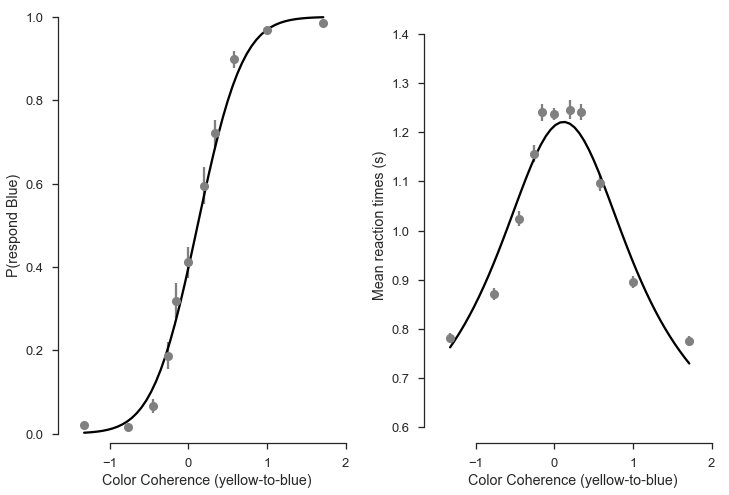

In [15]:
datadotsplot=np.column_stack([dots['color_coh'],dots['RT'],dots['choseblue'],dots['subjid']])
# Plot data with fits
plotDotsDataWithFit(datadotsplot, thetadots, dt=.0005)

### Color Dots stats

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choseblue ~ color_coh + (1 | subjid)
   Data: dots

     AIC      BIC   logLik deviance df.resid 
  4596.3   4616.5  -2295.2   4590.3     6197 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-101.793   -0.452   -0.012    0.411  156.662 

Random effects:
 Groups Name        Variance Std.Dev.
 subjid (Intercept) 0.6167   0.7853  
Number of obs: 6200, groups:  subjid, 30

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.2903     0.1481   -1.96     0.05 .  
color_coh     4.2193     0.1311   32.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
color_coh -0.028


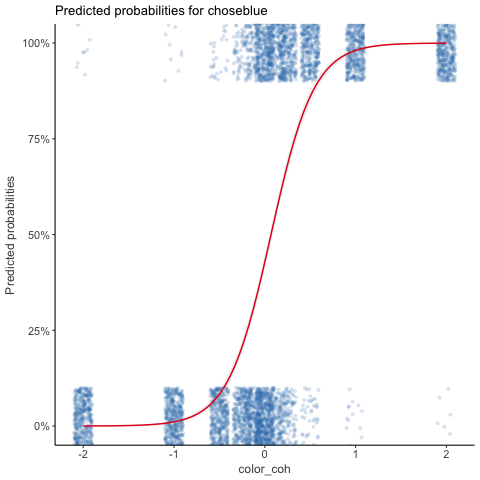

In [16]:
%%R -i dots
## there is no good package to run mixed effects logistic regression, using R's lme4 package
chosebluemod=glmer(choseblue ~ color_coh + (1|subjid), family='binomial', data=dots)
print(summary(chosebluemod))
sjp.setTheme(base = theme_classic())
sjp.glmer(chosebluemod,type='fe.slope',show.ci=T, show.values=T)

In [17]:
# RT mixed effects linear model using python's statsmodels
dots=dots.assign(abscolorcoh=dots['color_coh'].abs())
dotsmd = smf.mixedlm('RT ~ abscolorcoh', dots, groups=dots['subjid'])
dotsmdf = dotsmd.fit()
print(dotsmdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RT        
No. Observations: 6200    Method:             REML      
No. Groups:       30      Scale:              0.1026    
Min. group size:  189     Likelihood:         -1802.8426
Max. group size:  210     Converged:          Yes       
Mean group size:  206.7                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     1.227    0.029  42.955 0.000  1.171  1.283
abscolorcoh  -0.248    0.006 -41.624 0.000 -0.260 -0.236
groups RE     0.024    0.020                            



Linear mixed model fit by REML ['lmerMod']
Formula: RT ~ abscolorcoh + (1 | subjid)
   Data: dots

REML criterion at convergence: 3605.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5464 -0.6795 -0.1375  0.5215  5.2757 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjid   (Intercept) 0.0235   0.1533  
 Residual             0.1026   0.3203  
Number of obs: 6200, groups:  subjid, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.22668    0.02855   42.97
abscolorcoh -0.24809    0.00596  -41.62

Correlation of Fixed Effects:
            (Intr)
abscolorcoh -0.136


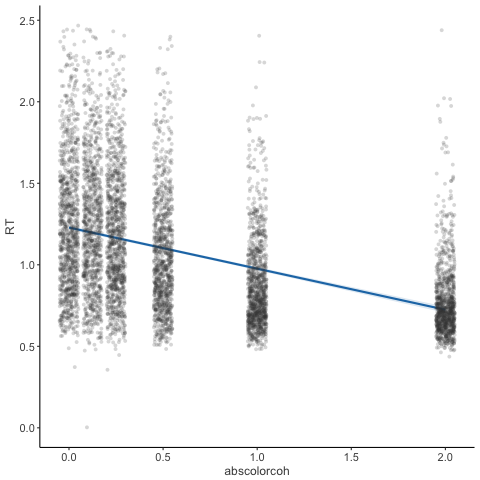

In [18]:
%%R -i dots
## compare the model using python's statsmodels (above) to R's lme4
dotsrtmod=lmer(RT ~ abscolorcoh + (1|subjid), data=dots)
print(summary(dotsrtmod))
sjp.lmer(dotsrtmod,type='fe.slope',show.ci=T, show.values=T, vars="abscolorcoh")

### Plot Dots data with fits per participant

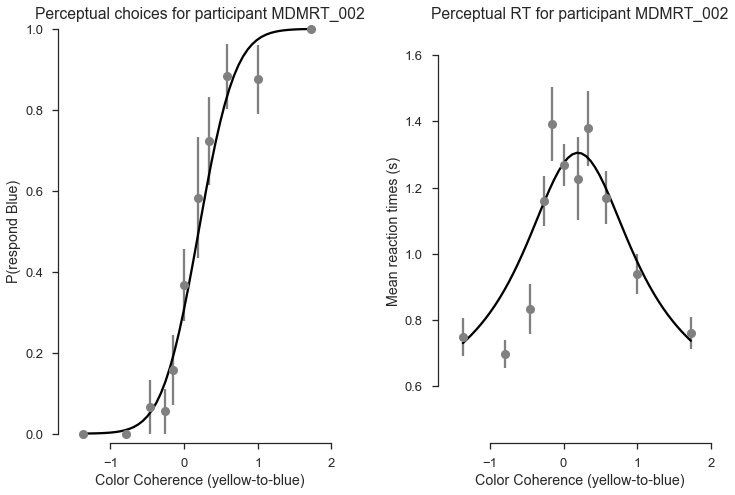

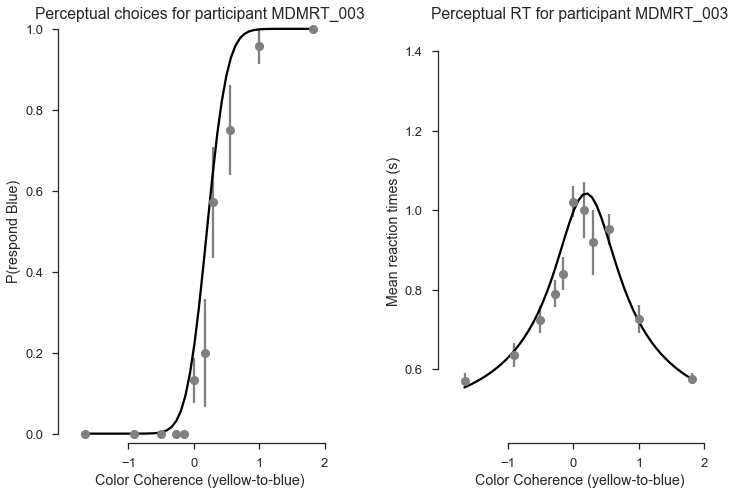

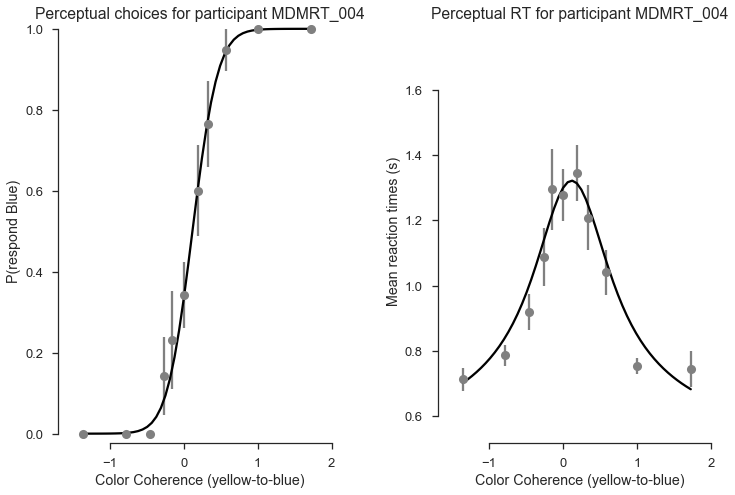

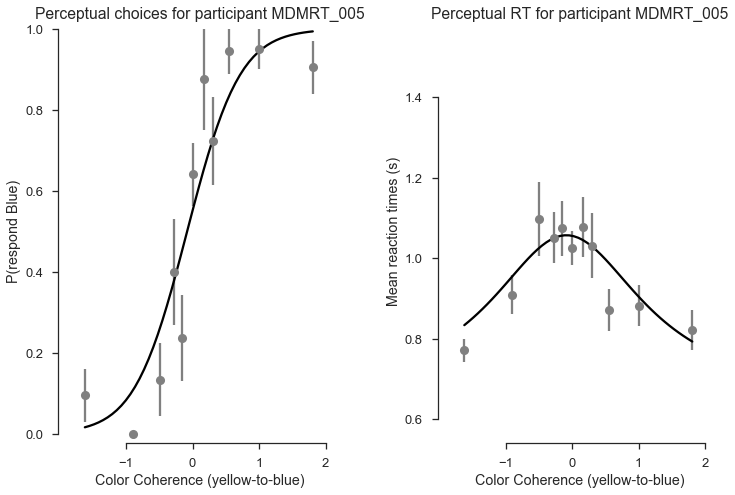

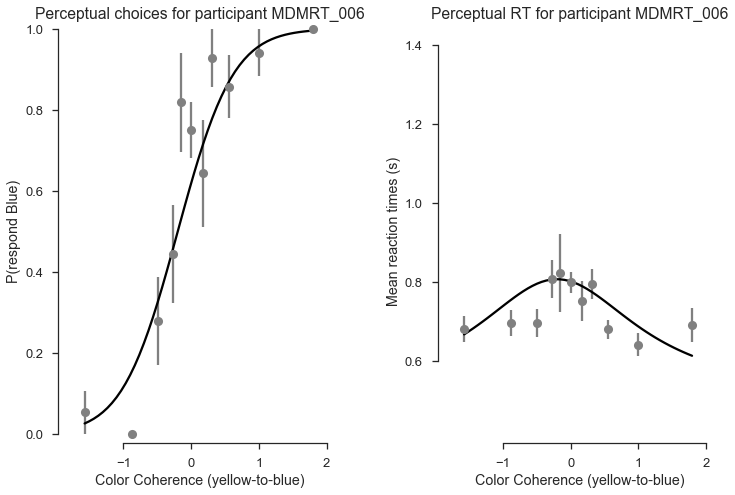

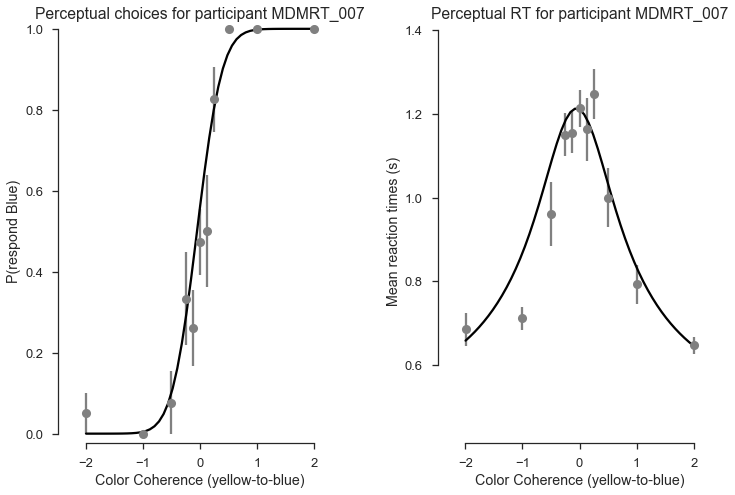

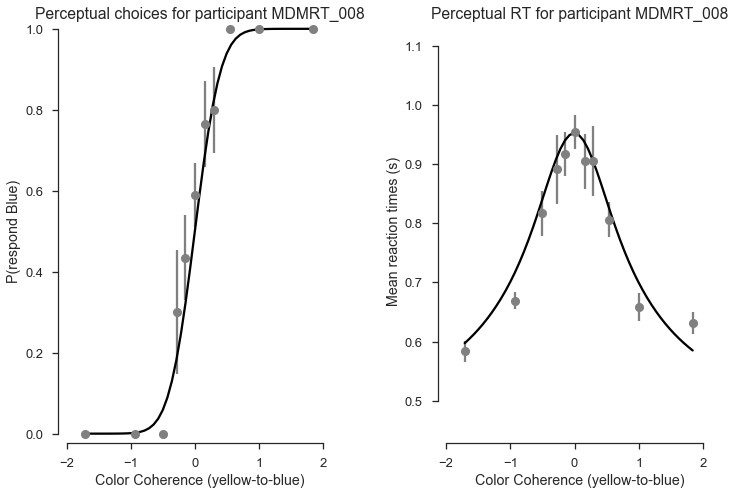

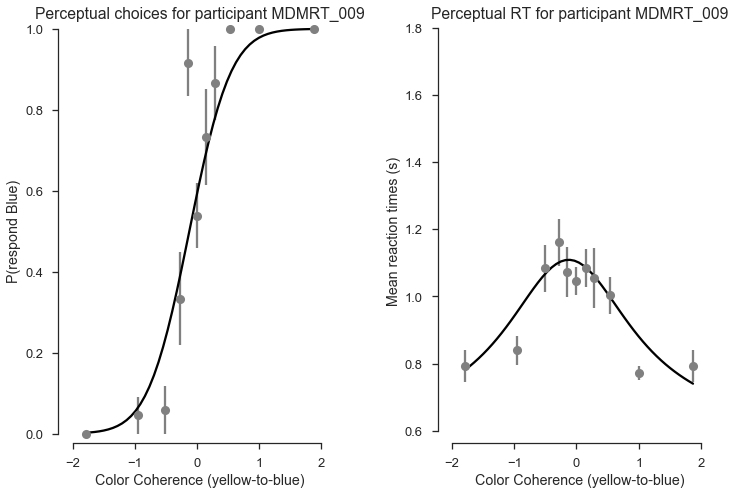

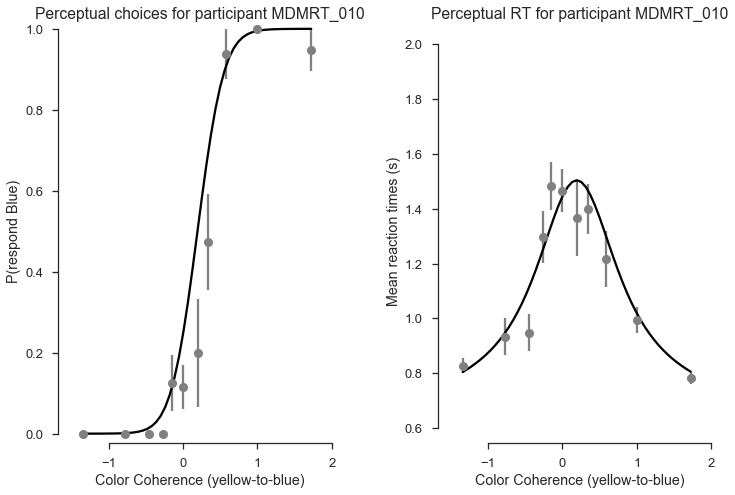

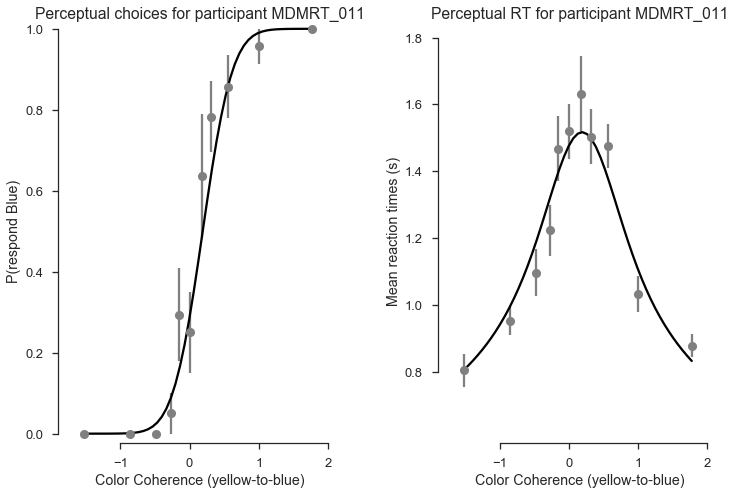

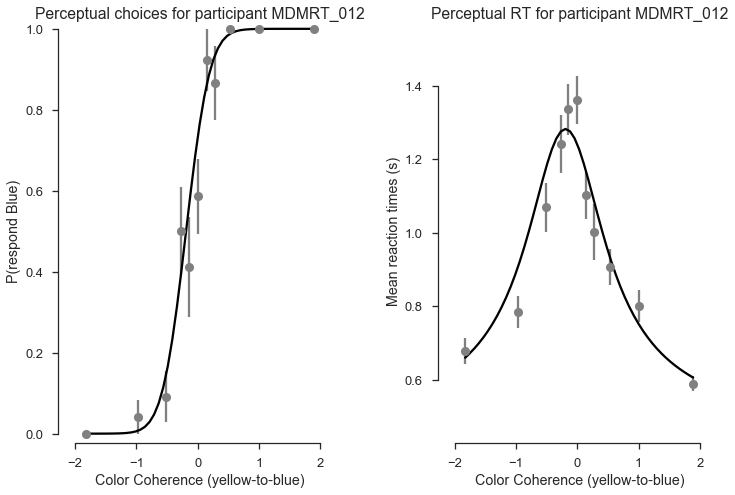

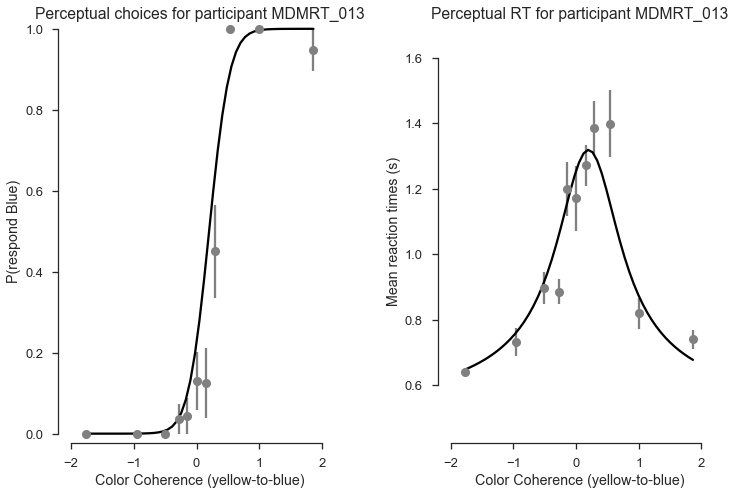

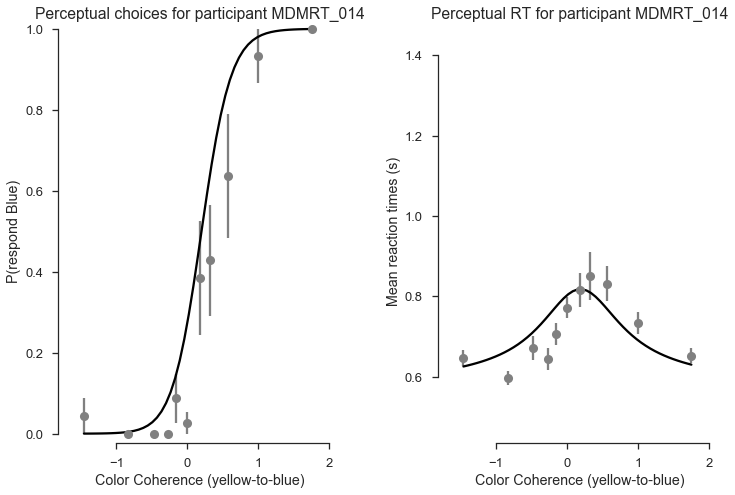

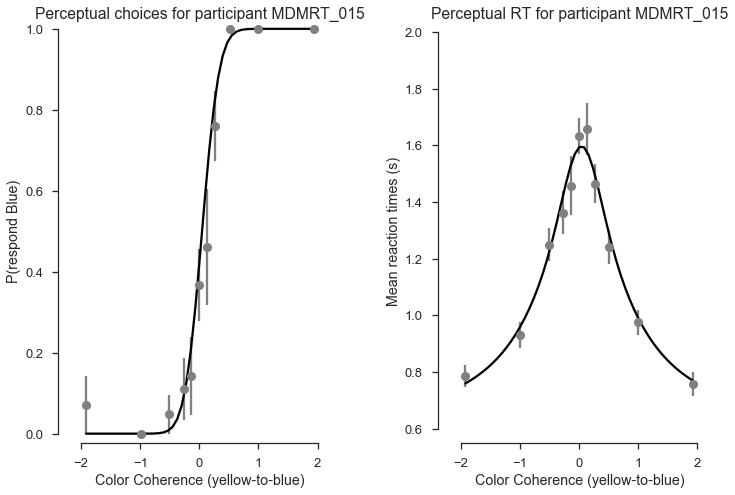

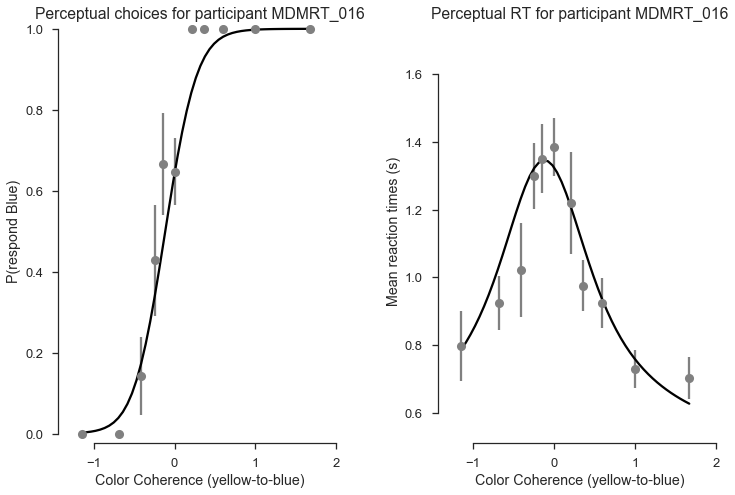

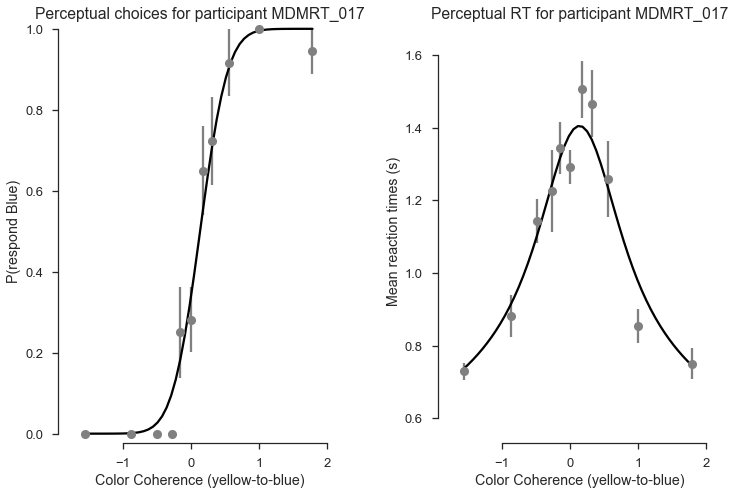

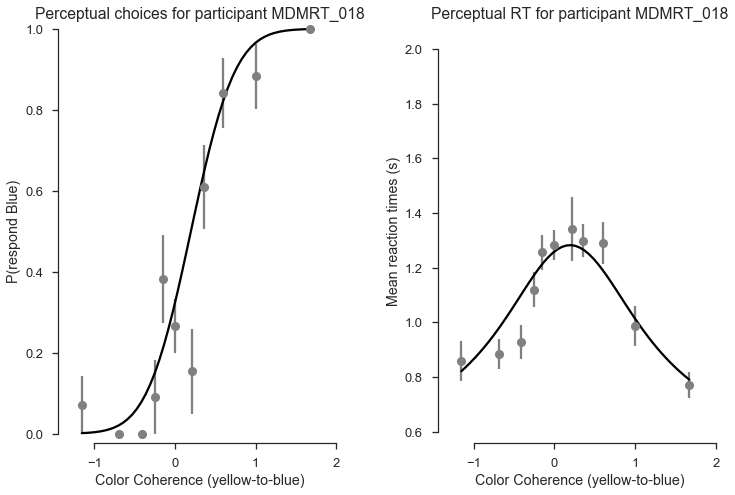

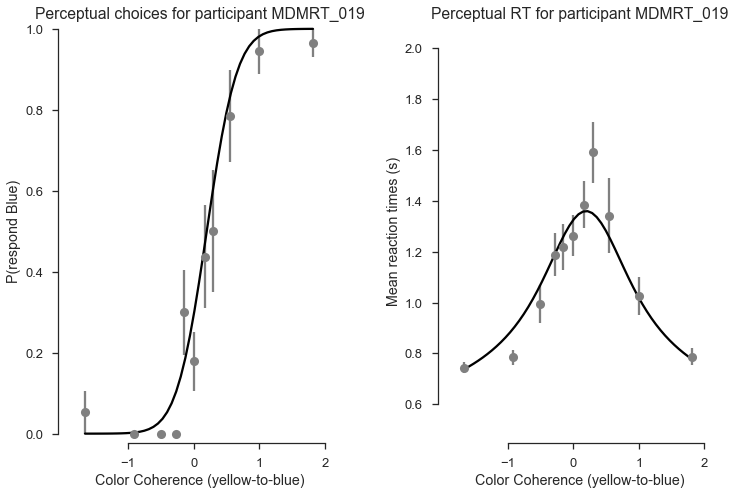

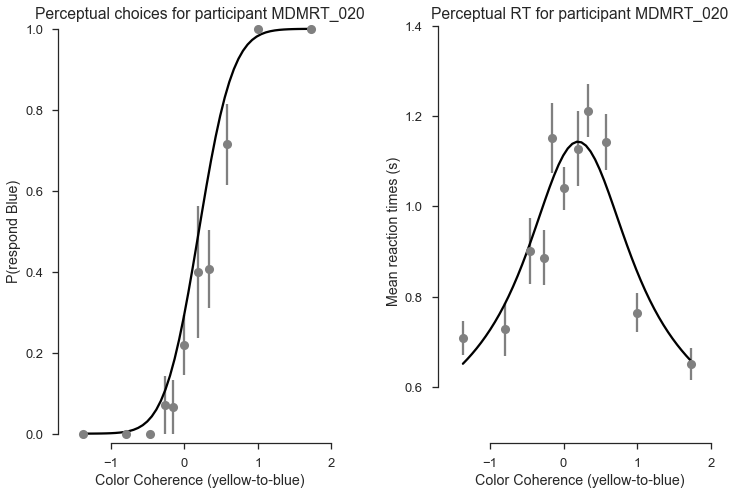

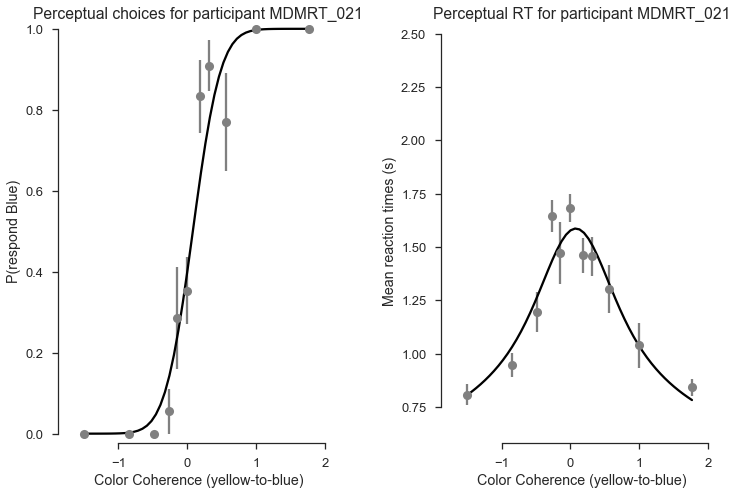

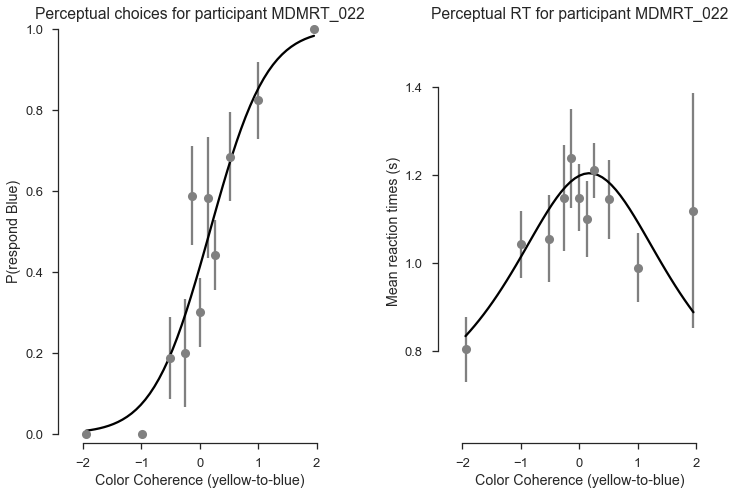

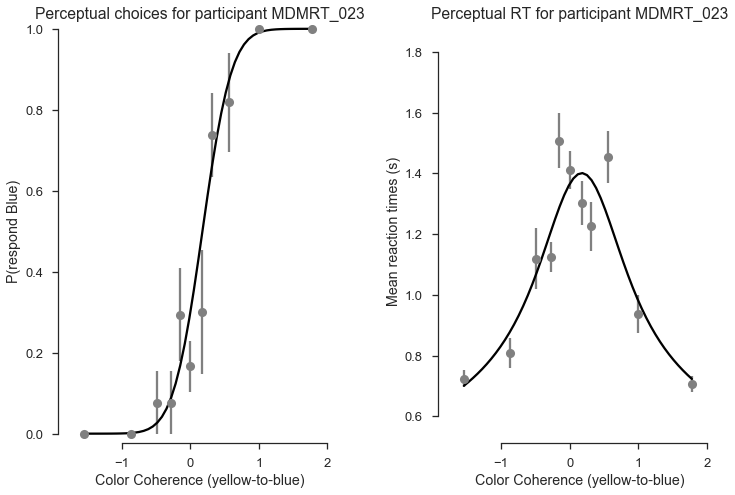

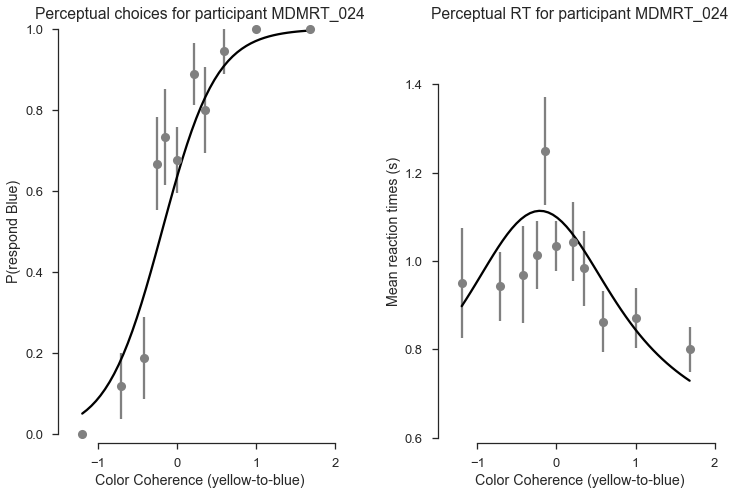

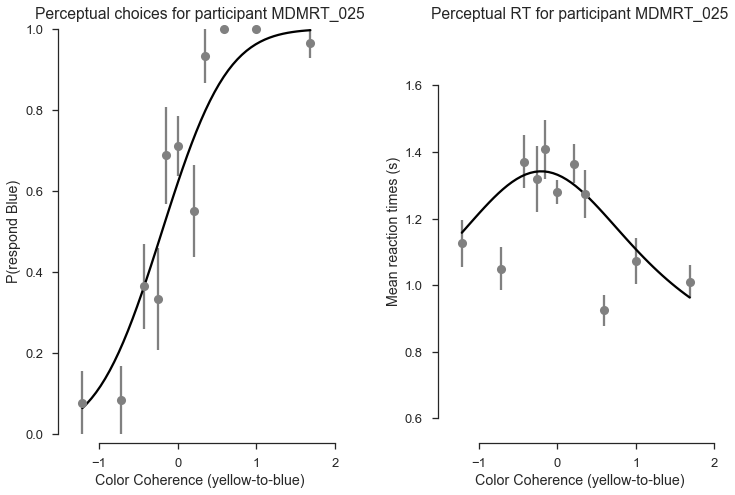

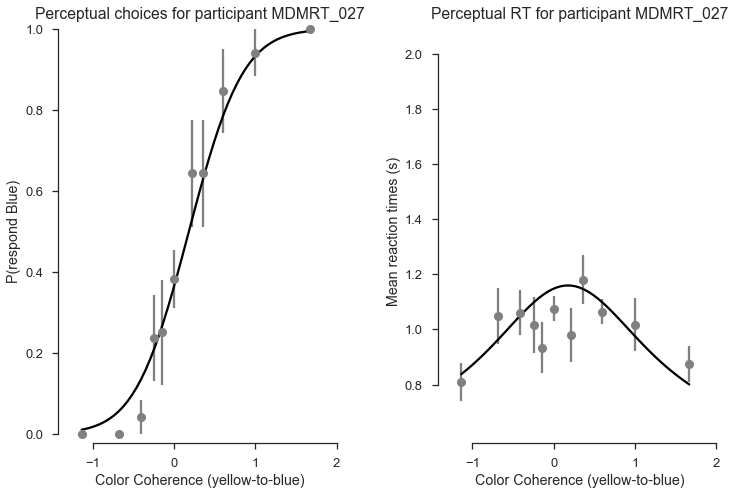

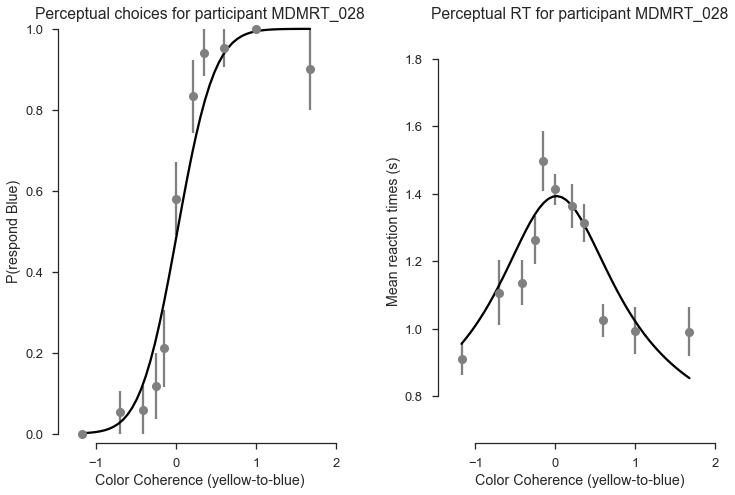

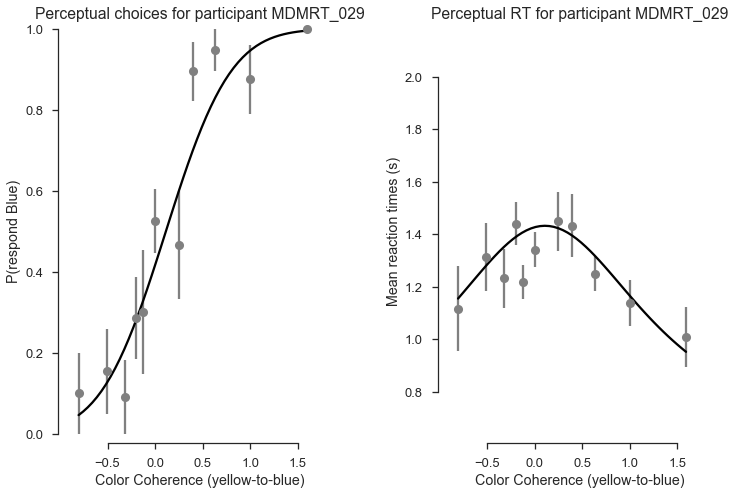

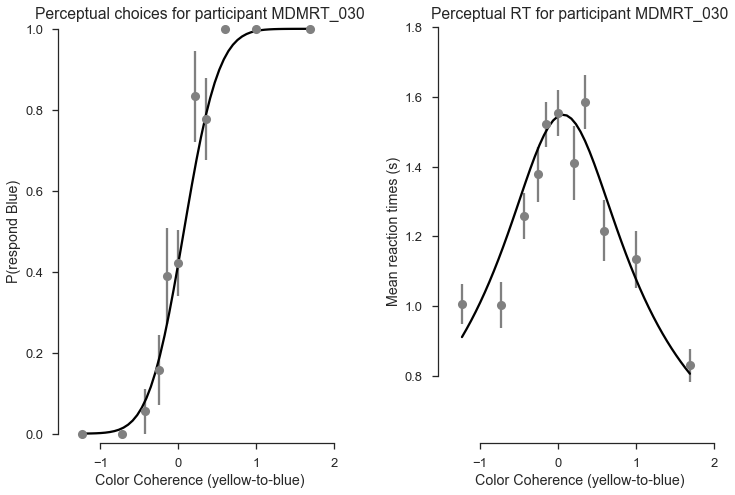

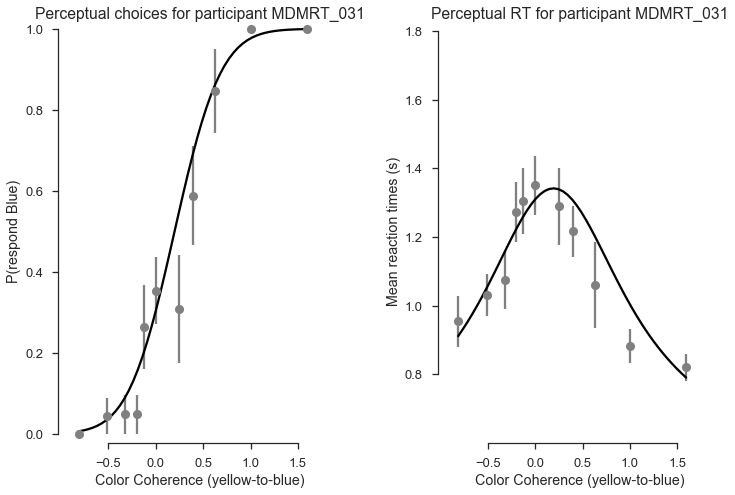

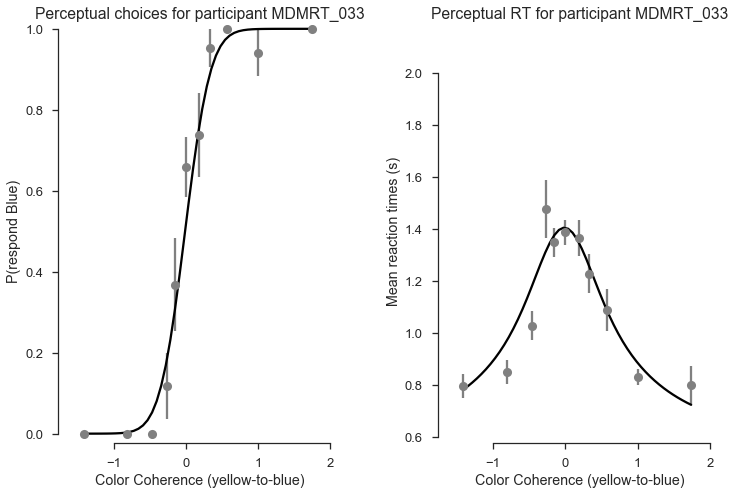

In [19]:
thetadots=pd.read_csv('/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Manuscript/Figures/thetas/dots_thetas_persub.csv')
for s in dots.subjid.unique():
    dotsub=dots.loc[dots['subjid']==s]
    datadotsub=np.column_stack([dotsub['color_coh'],dotsub['RT'],dotsub['choseblue']])
    #[thetadotssub,dotssubfopt]=fitData(datadotssub)
    thetadotsall=thetadots[thetadots.subjid==s]
    thetadotssub=thetadotsall.iloc[0].tolist()[2:-1]
    # Plot data with fits
    plotDotsubDataWithFit(datadotsub, thetadotssub, s, dt=.005)
    outputfit(datadotsub, thetadotssub, s, 'dots', dt=.0005)

## Food Choice
### Load in all dots task data

In [20]:
# make list of files
filelist=[]
for s in subjid:
    filelist=filelist+glob.glob(datapath+'MDMRT_'+str(s).zfill(3)+'_food_choice_run_*m.txt')

# load data into dataframe
food=pd.read_table(filelist[0],sep=" ")
filelist.remove(filelist[0])
for f in filelist:
    tmp=pd.read_table(f,sep=" ")
    food=pd.concat([food,tmp])

### Food Choice raw data plots

In [21]:
# only take valid trials
isvalidtrial=food['Response']!='x'
food=food[isvalidtrial]

# code chose right
food=food.assign(choseright=food['Response'] == '4$')

# calculate deltavalue
food=food.assign(deltaval=food['bidRight']-food['bidLeft'])

food['deltavalrnd']=food['deltaval'].round(1)
datafood=np.column_stack([food['deltavalrnd'],food['RT'],food['choseright']])


### Run fits on all trials and participants of food data

In [22]:
# fit to food
[thetafood,foodfopt]=fitData(datafood, dt=.0005)
#[thetafood,foodfopt]=[[1.02109378,1.07714882,0.15516395,0.3535432,0.51857002,0.09998154,-0.02186064,0,0.80811163],54119.61825]

### Plot all trials and participants of food data with fits

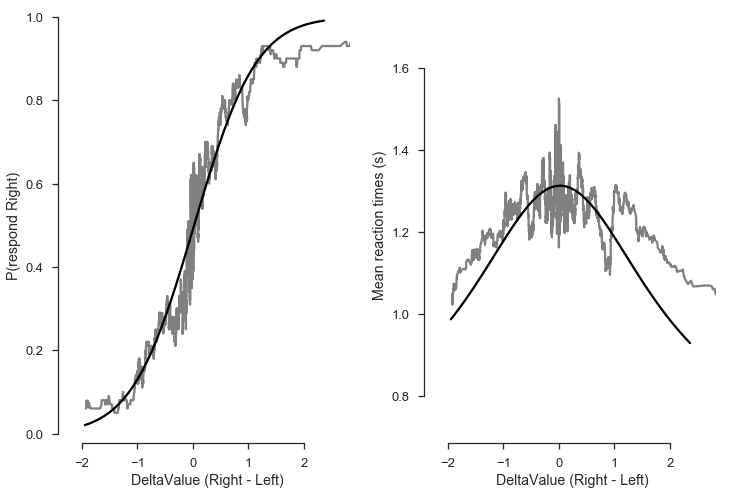

In [23]:
datafoodplot=np.column_stack([food['deltavalrnd'],food['RT'],food['choseright'],food['subjid'],food['deltaval']])
plotFoodDataWithFit(datafoodplot, thetafood, dt=.0005)

### Food Choice stats

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choseright ~ deltaval + (1 | subjid)
   Data: food

     AIC      BIC   logLik deviance df.resid 
  7726.2   7746.4  -3860.1   7720.2     6185 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-13.1080  -0.9548  -0.1891   0.9808   6.2511 

Random effects:
 Groups Name        Variance Std.Dev.
 subjid (Intercept) 0.0188   0.1371  
Number of obs: 6188, groups:  subjid, 30

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.01918    0.03698  -0.519    0.604    
deltaval     1.78106    0.07907  22.525   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
deltaval 0.031 


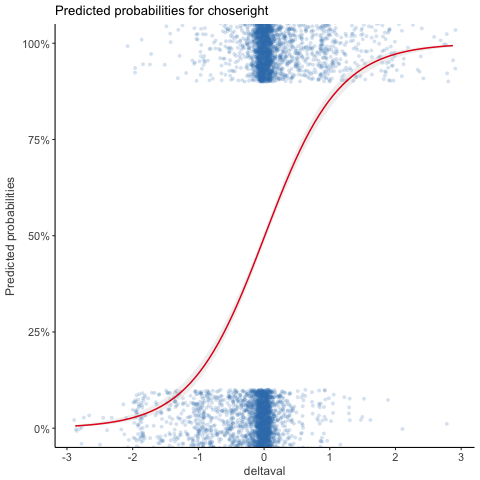

In [24]:
%%R -i food
choserightmod=glmer(choseright ~ deltaval + (1|subjid), family='binomial', data=food)
print(summary(choserightmod))
sjp.setTheme(base = theme_classic())
sjp.glmer(choserightmod,type='fe.slope',show.ci=T, show.values=T)

In [25]:
# RT mixed effects linear model
food=food.assign(absdeltaval=food['deltaval'].abs())
foodmd = smf.mixedlm('RT ~ absdeltaval', food, groups=food['subjid'])
foodmdf = foodmd.fit()
print(foodmdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RT        
No. Observations: 6188    Method:             REML      
No. Groups:       30      Scale:              0.1587    
Min. group size:  185     Likelihood:         -3152.0425
Max. group size:  210     Converged:          Yes       
Mean group size:  206.3                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     1.315    0.040  32.930 0.000  1.237  1.394
absdeltaval  -0.109    0.011 -10.219 0.000 -0.130 -0.088
groups RE     0.047    0.031                            



Linear mixed model fit by REML ['lmerMod']
Formula: RT ~ absdeltaval + (1 | subjid)
   Data: food

REML criterion at convergence: 6304.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7386 -0.6745 -0.1526  0.5108  4.4260 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjid   (Intercept) 0.04682  0.2164  
 Residual             0.15871  0.3984  
Number of obs: 6188, groups:  subjid, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.31526    0.03996   32.91
absdeltaval -0.10905    0.01067  -10.22

Correlation of Fixed Effects:
            (Intr)
absdeltaval -0.081


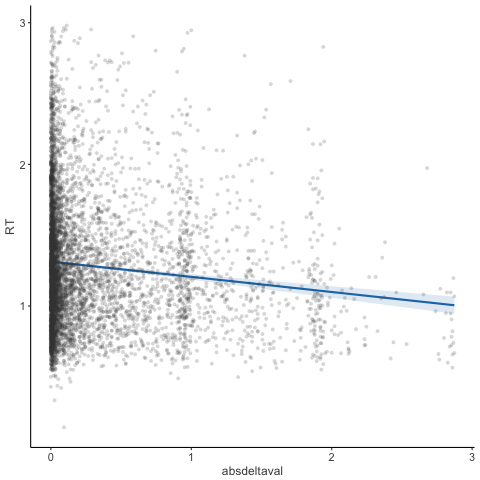

In [26]:
%%R -i food
## compare the model using python's statsmodels to R's lme4
foodrtmod=lmer(RT ~ absdeltaval + (1|subjid), data=food)
print(summary(foodrtmod))
sjp.lmer(foodrtmod,type='fe.slope',show.ci=T, show.values=T, vars='absdeltaval')

### Plot trials per participants of food data with fits

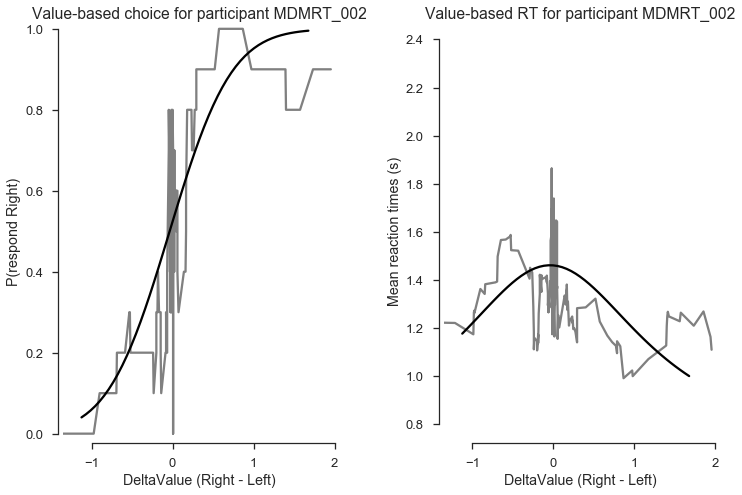

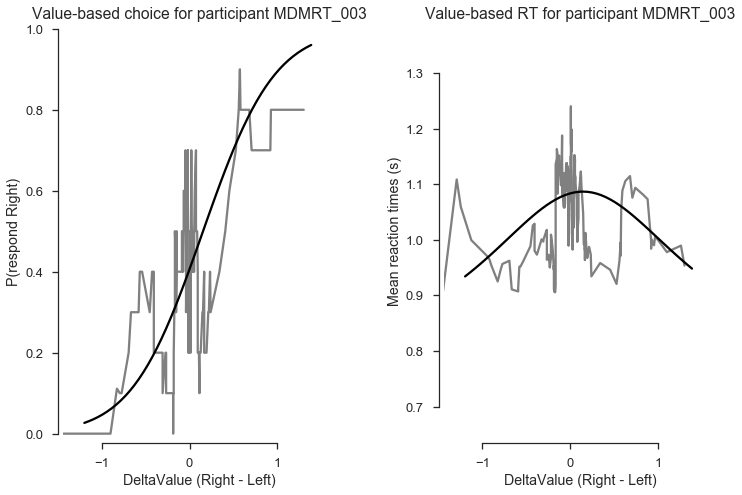

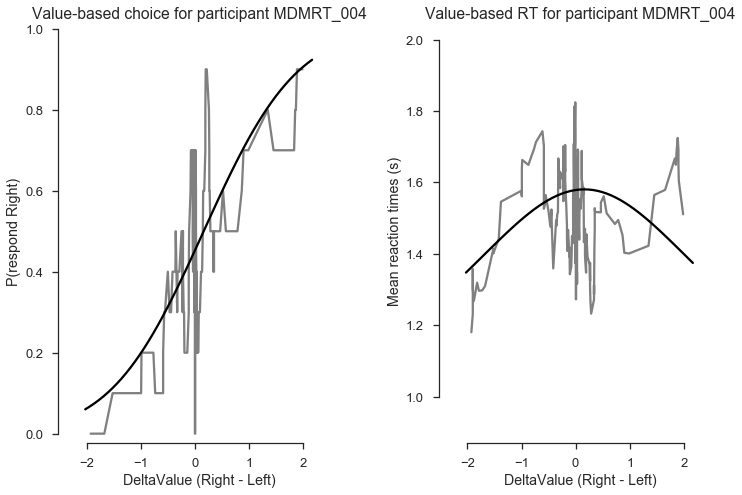

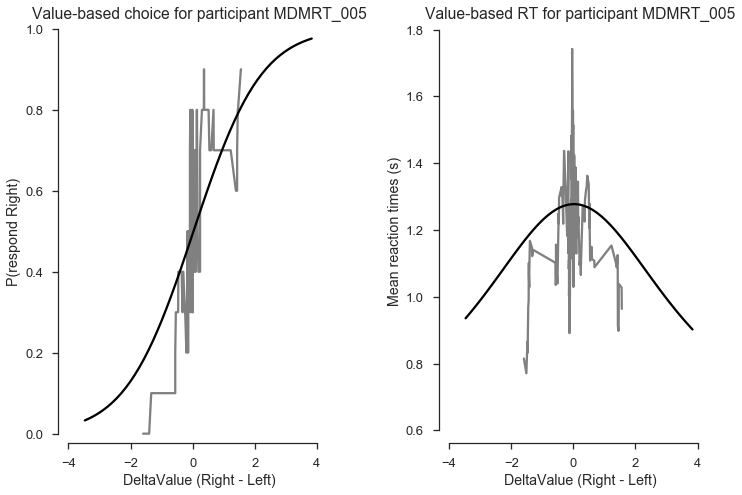

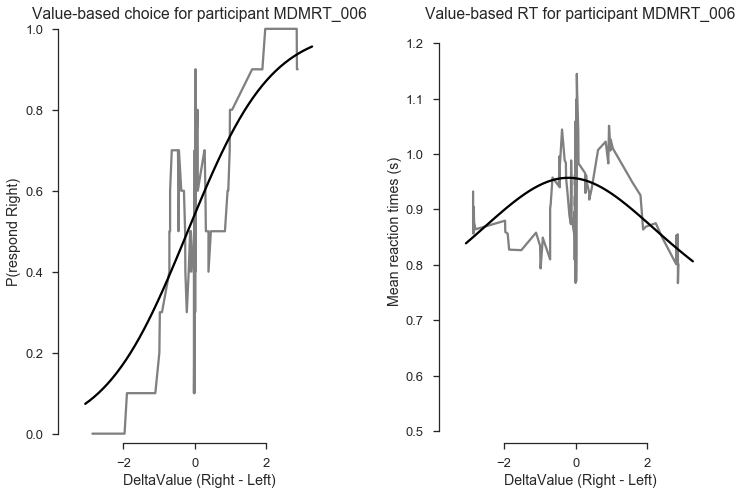

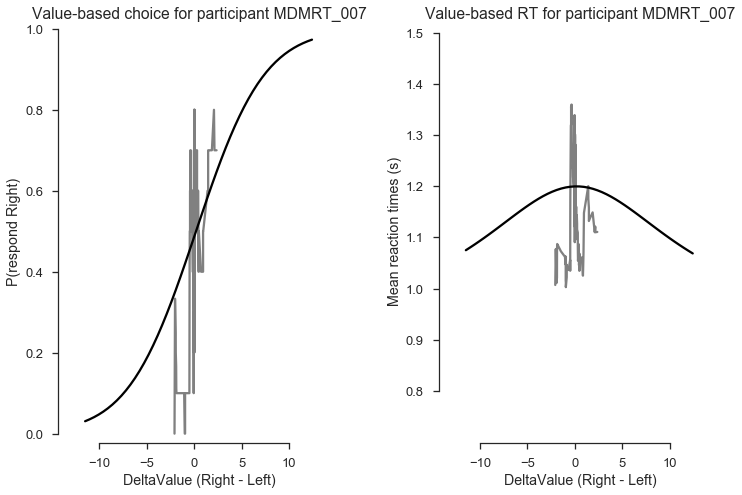

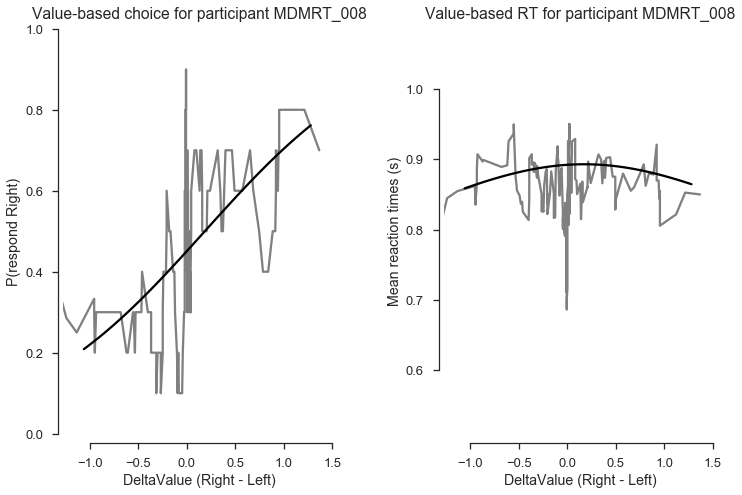

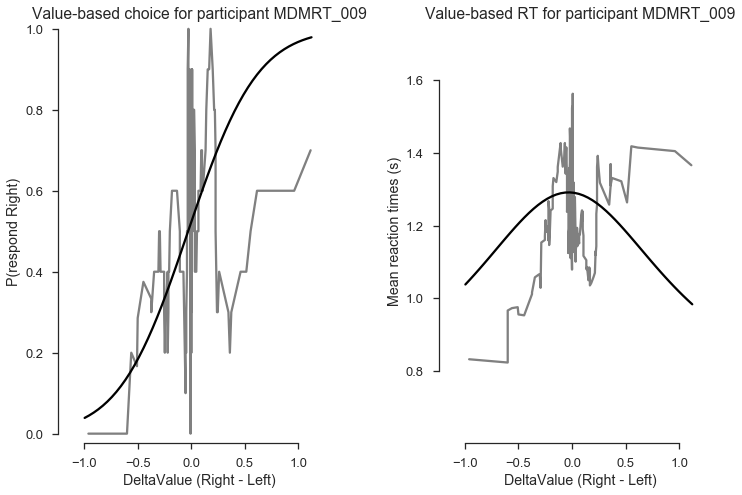

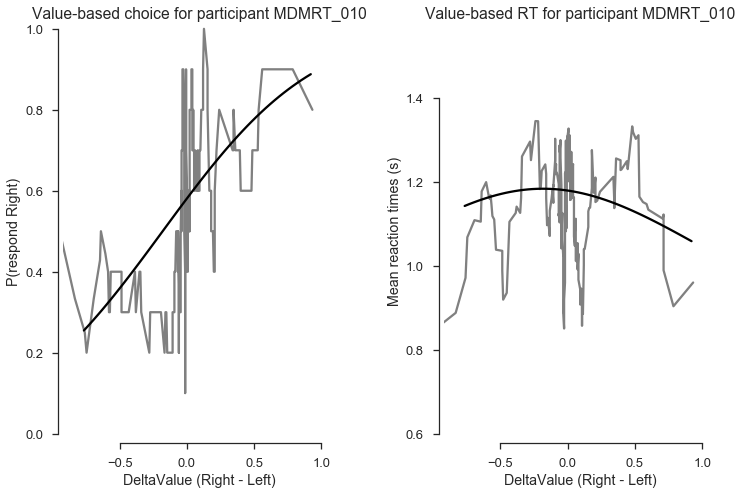

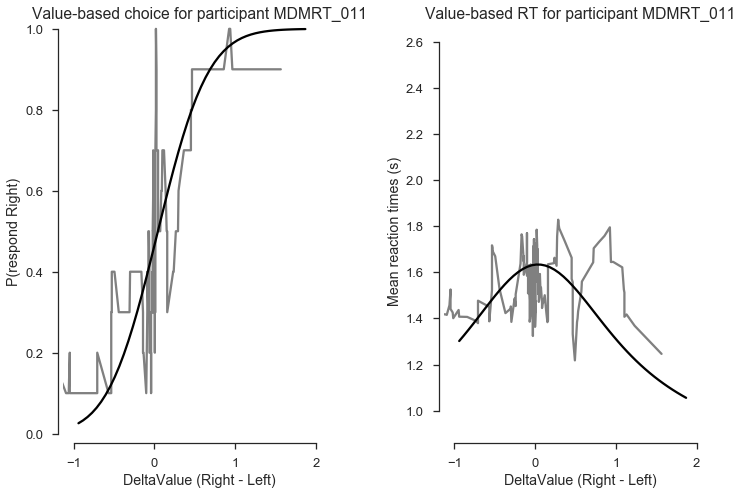

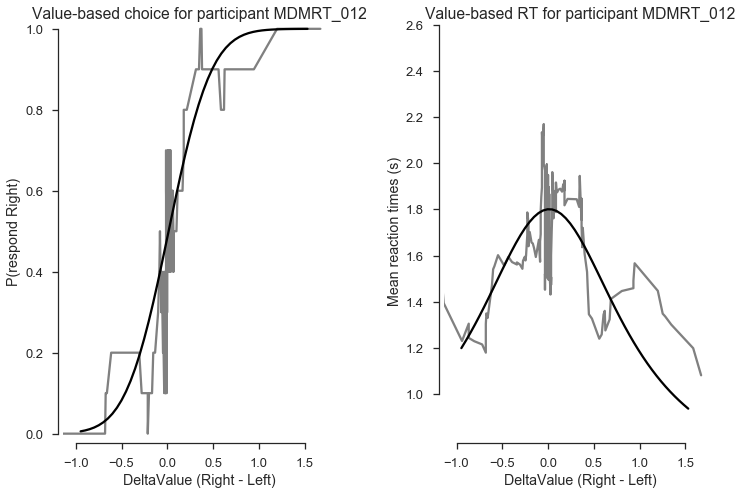

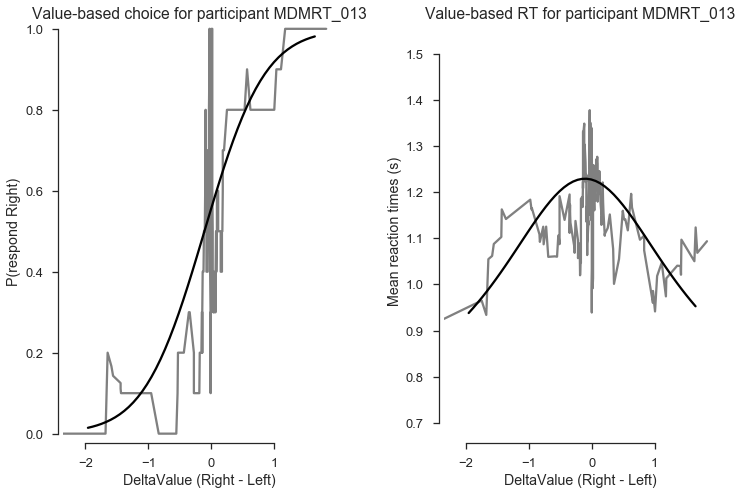

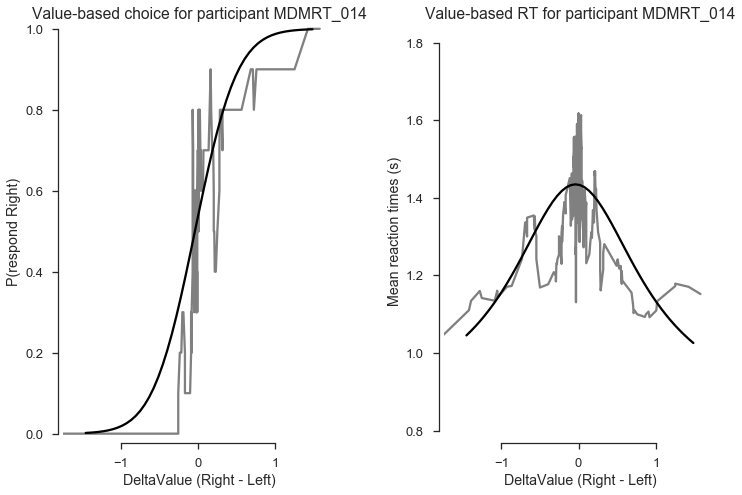

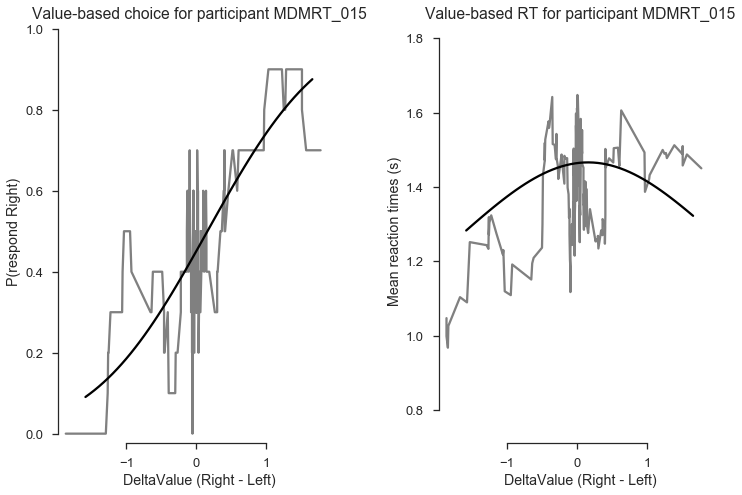

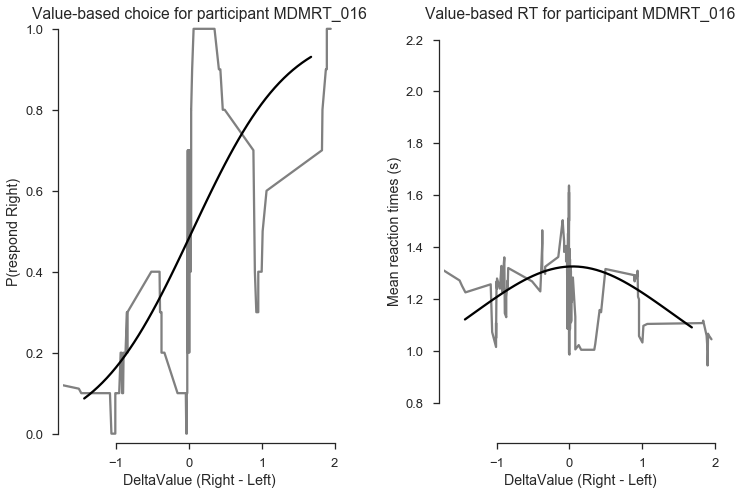

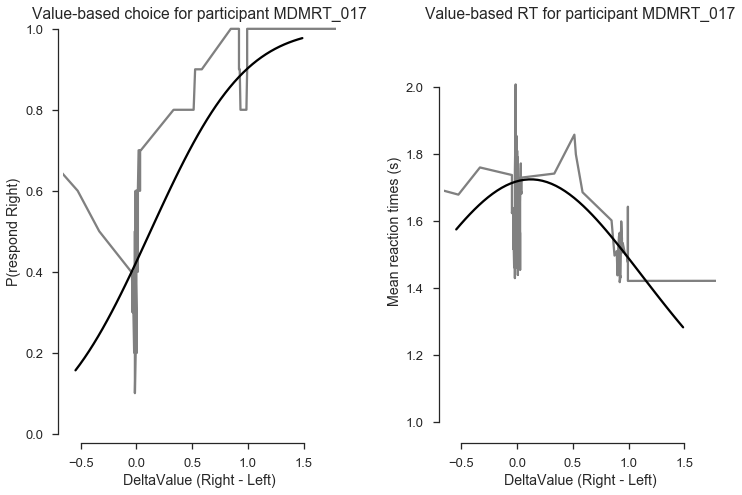

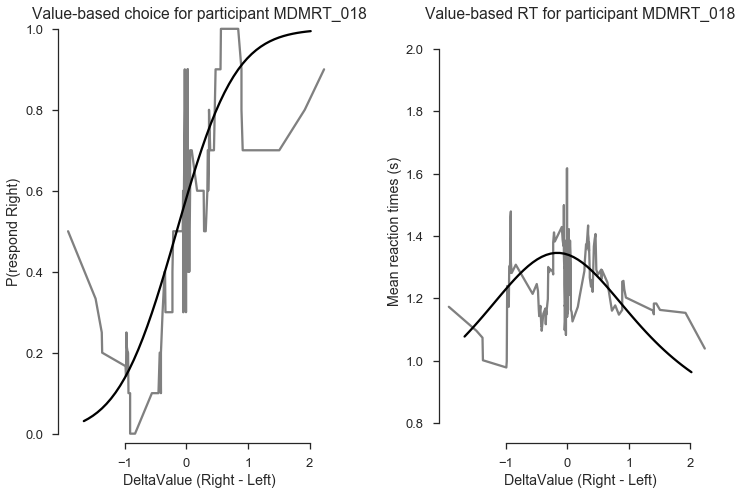

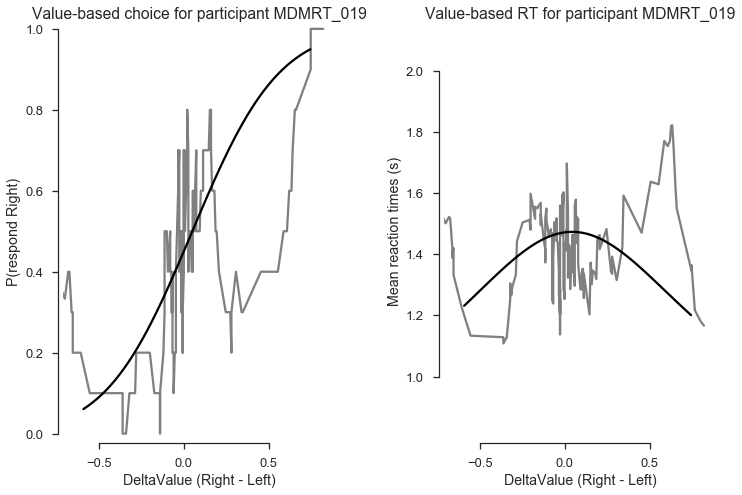

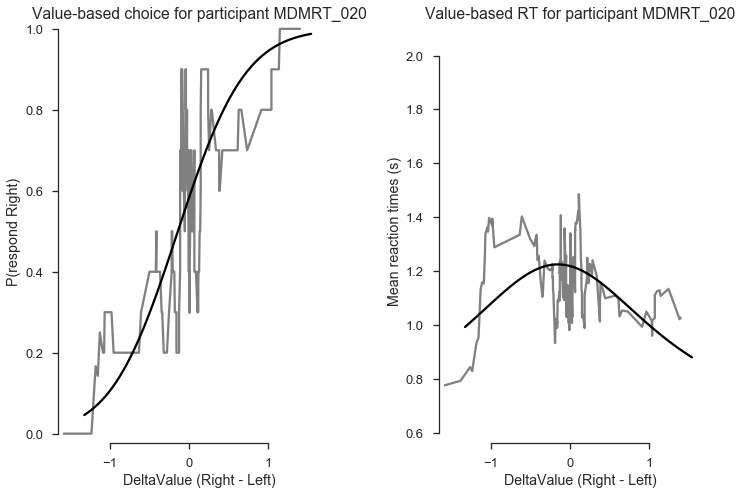

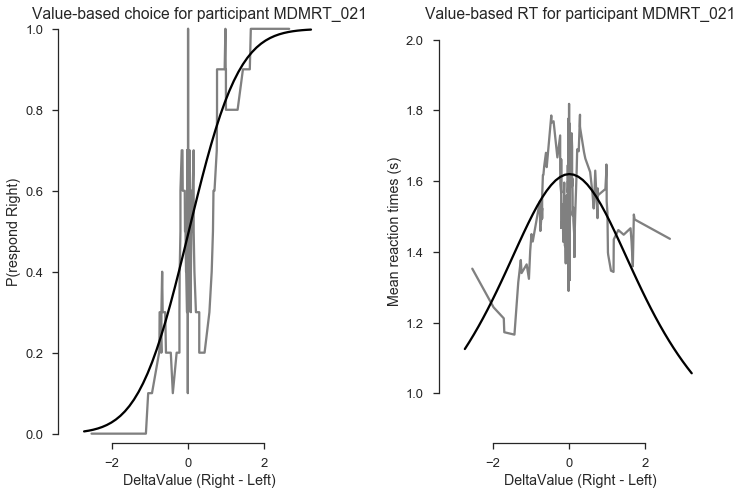

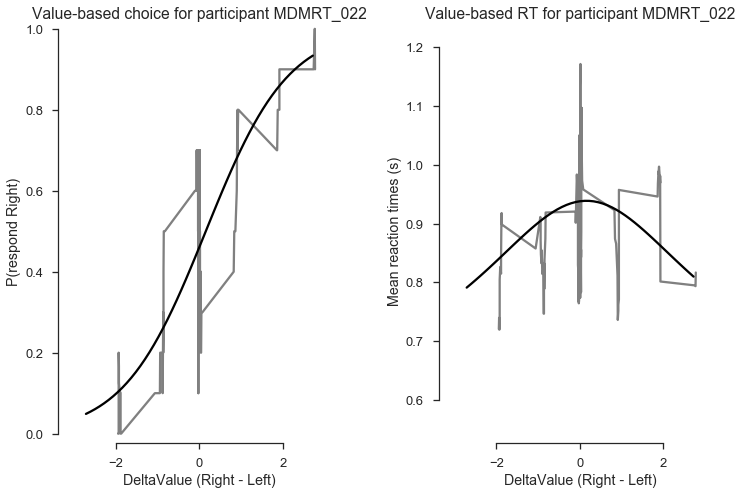

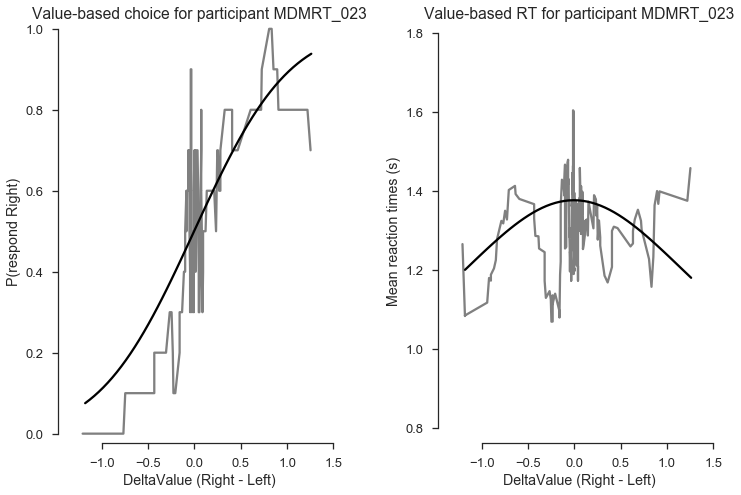

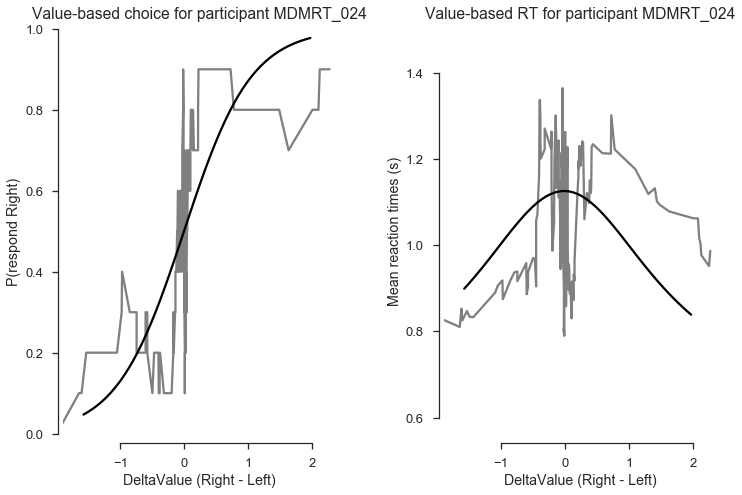

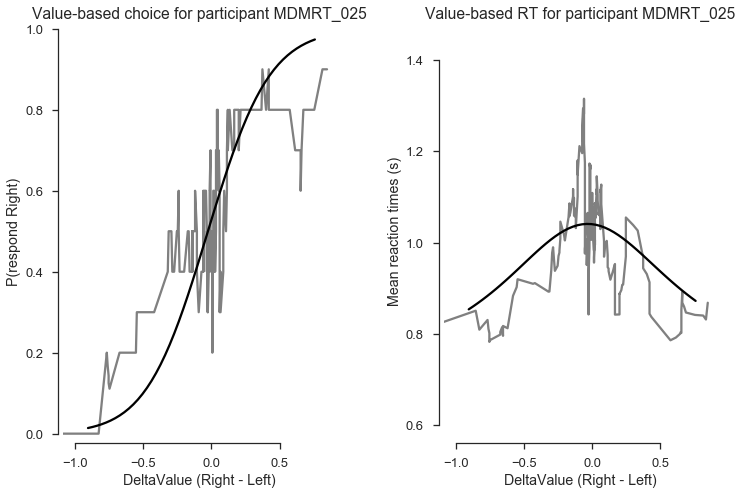

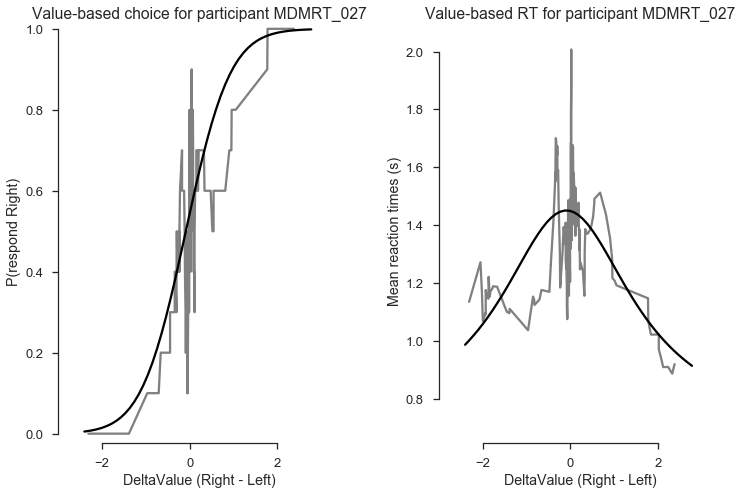

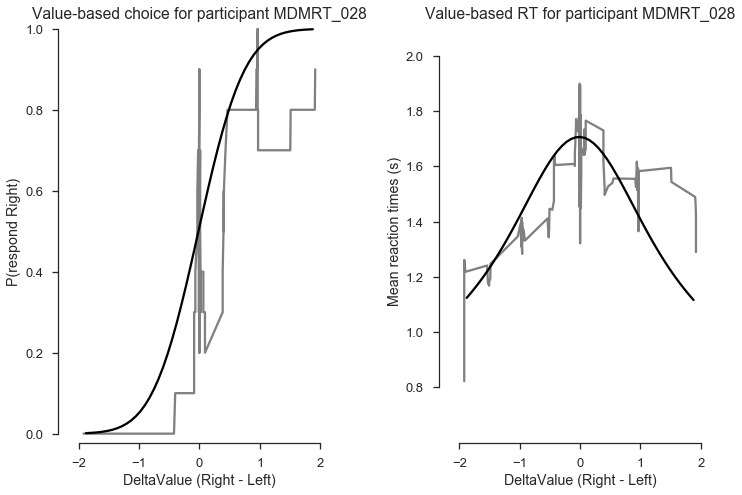

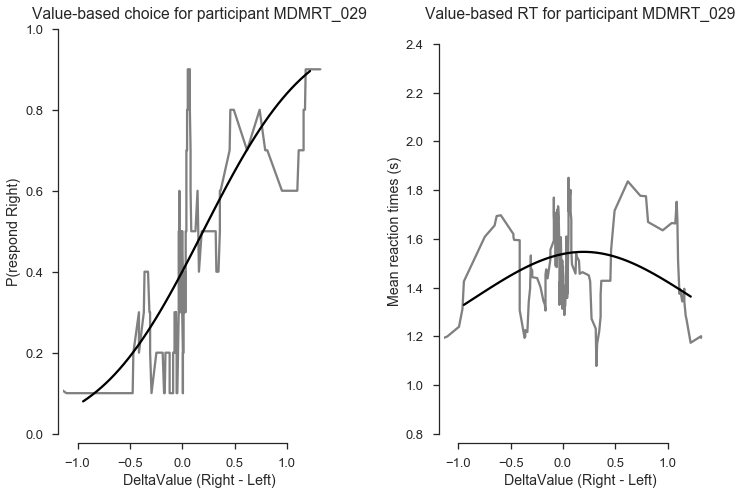

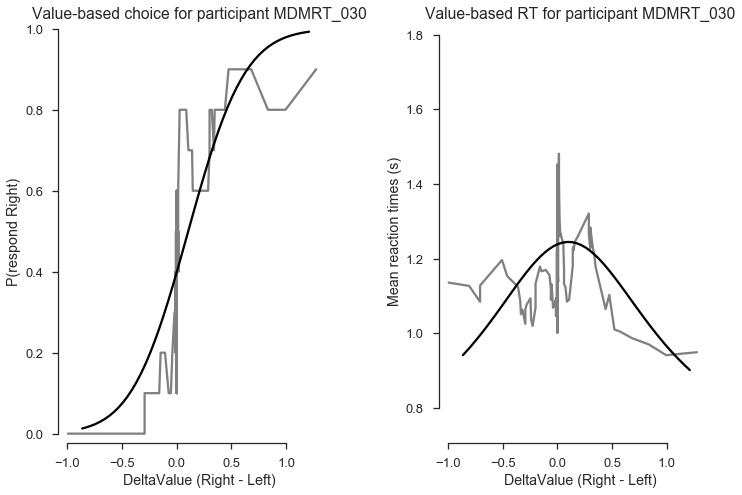

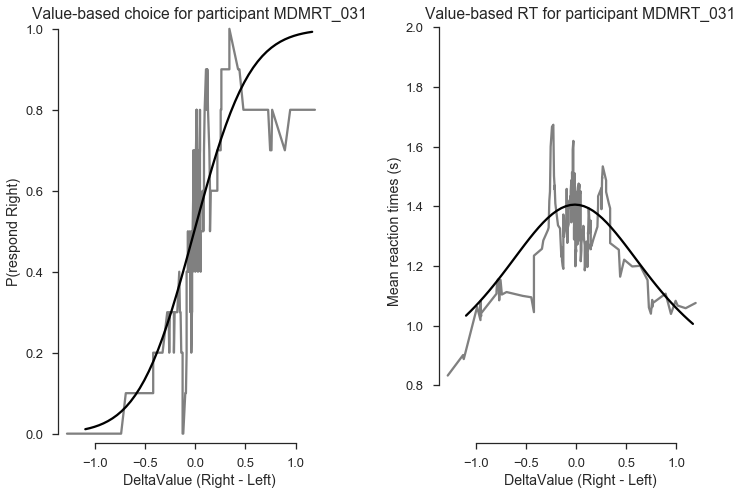

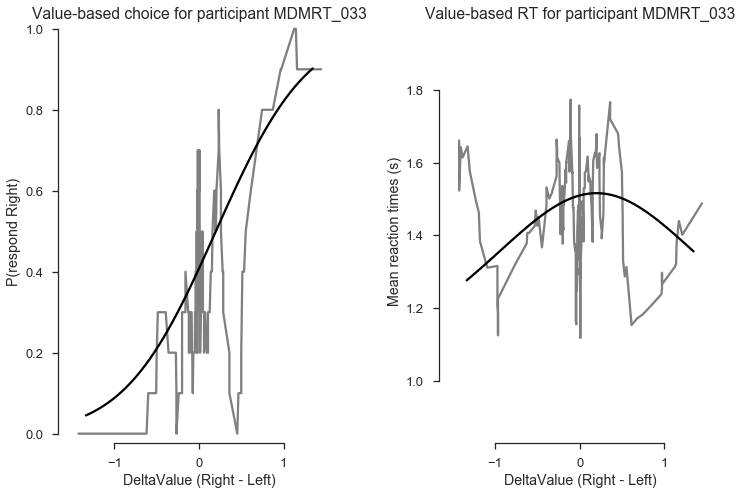

In [27]:
thetafood=pd.read_csv('/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Manuscript/Figures/thetas/food_thetas_persub.csv')
for s in food.subjid.unique():
    foodsub=food.loc[food['subjid']==s]
    datafoodsub=np.column_stack([foodsub['deltavalrnd'],foodsub['RT'],foodsub['choseright'],foodsub['deltaval']])
    #[thetafoodsub,foodsubfopt]=fitData(foodsub)    
    thetafoodall=thetafood[thetafood.subjid==s]
    thetafoodsub=thetafoodall.iloc[0].tolist()[2:-1]
    # Plot data with fits
    plotFoodsubDataWithFit(datafoodsub, thetafoodsub, s, dt=.005)
    outputfit(datafoodsub, thetafoodsub, s, 'food', dt=.0005)

## fMRI maps
### Memory Hits > Correct Rejections

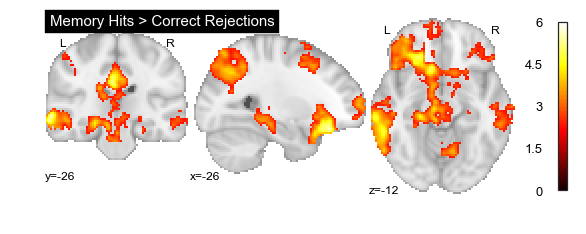

In [28]:
## path to imaging data
imgpath='/Volumes/hypatia/akram/MDMRT_scan'


## Map of Memory hits > correct rejections model001 task003 cope014 
memory_map=nilearn.image.load_img(imgpath +'/group/model001/task003/cope014.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(memory_map,cut_coords=[-26,-26,-12],draw_cross=False, 
                               title="Memory Hits > Correct Rejections")
plt.show()


### Conjunction Map of (Value-based RT > Perceptual RT) & (Memory hits > correct rejections)

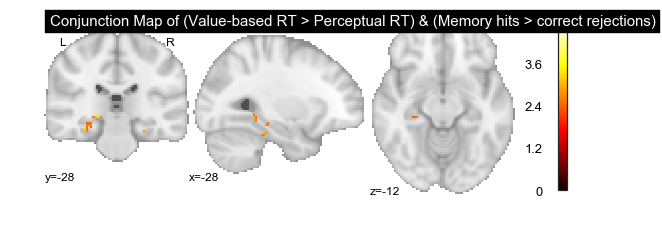

In [29]:
## Conjunction Map of (Value-based RT > Perceptual RT: model002 t1c2mint2c2 cope001) & (Memory hits > correct rejections model001 task003 cope014)

conjunction_map=nilearn.image.load_img(imgpath +'/group/model002/task1_v_task2/t1_rtall_v_t2_rtall_conj_memHitsvCR.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(conjunction_map,cut_coords=[-28,-28,-12],draw_cross=False, 
                               title="Conjunction Map of (Value-based RT > Perceptual RT) & (Memory hits > correct rejections)")
plt.show()

### Map of Main effect (intercept) of Value-based onset > Perceptual onset

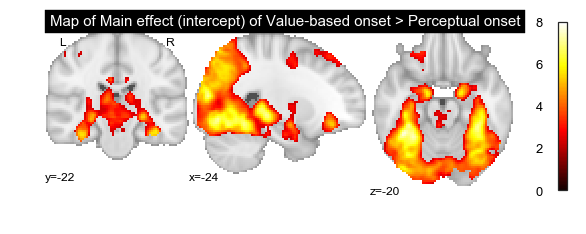

In [30]:
## Map of Main effect (intercept) of Value-based onset > Perceptual onset

t1vt2_onset_map=nilearn.image.load_img(imgpath +'/group/model002/task1_v_task2/t1c1mint2c1.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(t1vt2_onset_map,cut_coords=[-24,-22,-20],draw_cross=False, 
                               title="Map of Main effect (intercept) of Value-based onset > Perceptual onset")
plt.show()


### Map of Value-based RT (range restricted) > Perceptual RT (range restricted)

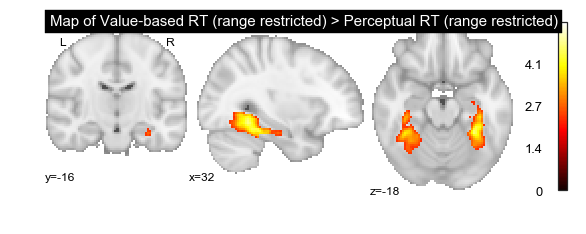

In [31]:
## Map of Value-based RT (range restricted) > Perceptual RT (range restricted) to RT range overlap between two tasks:

t1vt2rtrestricted_map=nilearn.image.load_img(imgpath +'/group/model003/task1_v_task2/t1c2vt2c2.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(t1vt2rtrestricted_map,cut_coords=[32,-16,-18],draw_cross=False, 
                               title="Map of Value-based RT (range restricted) > Perceptual RT (range restricted)")
plt.show()

### Maps of VB RT, Perceptual RT, and VB RT > Perceptual RT

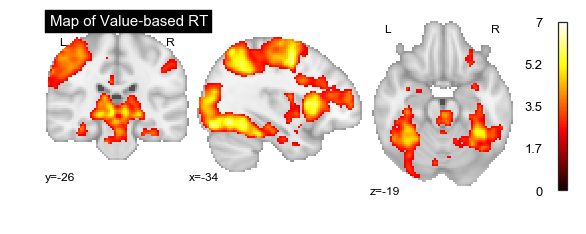

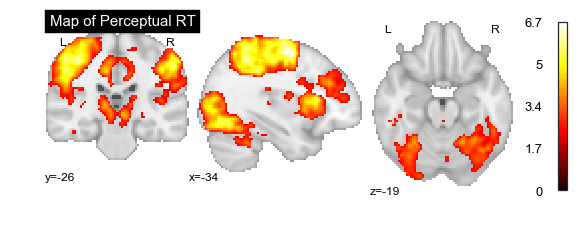

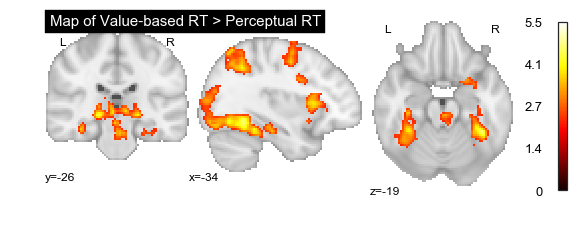

In [32]:
## Map of Value-based RT:
t1rt_map=nilearn.image.load_img(imgpath +'/group/model007/task001/cope014.gfeat/cope1.feat/thresh_zstat1.nii.gz')
nilearn.plotting.plot_stat_map(t1rt_map,cut_coords=[-34,-26,-19],draw_cross=False, 
                               title="Map of Value-based RT")

## Map of Perceptual RT:
t2rt_map=nilearn.image.load_img(imgpath +'/group/model007/task002/cope010.gfeat/cope1.feat/thresh_zstat1.nii.gz')
nilearn.plotting.plot_stat_map(t2rt_map,cut_coords=[-34,-26,-19],draw_cross=False, 
                               title="Map of Perceptual RT")

## Map of (Value-based RT > Perceptual RT: model007 t1c2mint2c2 cope001)
t1vt2rt_map=nilearn.image.load_img(imgpath +'/group/model007/task1_v_task2/t1_rtall_v_t2_rtall.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(t1vt2rt_map,cut_coords=[-34,-26,-19],draw_cross=False, 
                               title="Map of Value-based RT > Perceptual RT")
plt.show()

### PPI with hippocapus seed for Fast > Slow VB decisions

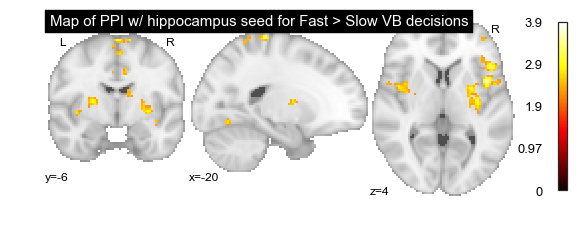

In [33]:
## PPI map with hippocampus seed for Fast > Slow VB decisions:
ppi_map=nilearn.image.load_img(imgpath +'/group/model010/task001/cope011.gfeat/cope1.feat/thresh_zstat1.nii.gz')
nilearn.plotting.plot_stat_map(ppi_map,cut_coords=[-20,-6,4],draw_cross=False, 
                               title="Map of PPI w/ hippocampus seed for Fast > Slow VB decisions")
plt.show()

## Revalued Values
### Calculate Revalued Values based on actual trial order

In [34]:
## Calculate revalued values

def fn_reval(delta_v,foodsub):
    # get number of trials
    ntrials=len(foodsub['subjid'])
    # make empty dataframe to populate with revalued values
    revalsub=pd.DataFrame(np.zeros((ntrials,2)),columns=['RevalueLeft','RevalueRight'])
    # get item names placed on left and right side of screen for all trials
    item=foodsub['ImageLeft']
    item=item.append(foodsub['ImageRight'])
    # get initial auction values for items on left and right for all trials
    value=foodsub['bidLeft']
    value=value.append(foodsub['bidRight'])
    # create a dataframe with item names and initial auction values
    tmp=pd.DataFrame({'item':item,'value':value})
    # create dataframe with 60 item names and initial auction values to be updated per trial
    value=tmp.groupby(['item'],as_index=False).mean()
    # go through trials to update values
    for t in range(ntrials):
        # get values for item on left and right from updated value dataframe
        valueleft=value[value['item']==foodsub.iloc[t]['ImageLeft']]['value']
        valueright=value[value['item']==foodsub.iloc[t]['ImageRight']]['value']
        # assign updated value for items on left and right on current trial
        revalsub.iloc[t]['RevalueLeft']= valueleft
        revalsub.iloc[t]['RevalueRight']= valueright
        # if right item chosen, increment value of item on right and decrement value of item on left
        if foodsub.iloc[t]['choseright']:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft - delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright + delta_v
        # else if left item chosen, increment value of item on left and decrement value of item on right
        else:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft + delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright - delta_v
    # calculate deltaval from revalued values
    revalsub['deltareval']=revalsub['RevalueRight'].values-revalsub['RevalueLeft'].values
    # choices and subject columns in ravalued dataframe
    revalsub['choseright']=foodsub['choseright'].values.astype('bool')
    revalsub['RT']=foodsub['RT'].values
    revalsub['ImageRight']=foodsub['ImageRight'].values
    revalsub['ImageLeft']=foodsub['ImageLeft'].values
    revalsub['subjid']=foodsub['subjid'].values
    # calculate goodness of fit to revalued values and output deviance
    mod=smf.glm('choseright ~ RevalueLeft + RevalueRight', data=revalsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub, revalsub

def do_optim(s):
    tlow=-0.6
    thigh=0.6
    food=pd.read_csv('food.csv',header=0,index_col=0)
    uni_subj=food['subjid'].unique()
    foodsub=food[food['subjid']==uni_subj[s]]
    fn_fit = lambda x: fn_reval(x, foodsub)[0]
    # eval best delta_v:
    xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
    dev_opt=[uni_subj[s],fn_fit(xopt),xopt]
    return dev_opt


In [35]:
# run 30 participants in parallel
inputs = range(len(food['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim)(i) for i in inputs)
# convert output to dataframe to make life easier
dev_opt=pd.DataFrame(results,columns=['subjid','opt_dev','opt_deltav'])

In [36]:
dev_opt = pickle.load( open( "dev_opt.p", "rb" ) )

### Caculate Revalued Values based on fake choices

In [37]:
# calculate the optimal delta_v if choices are sampled from a logistic
# seed
logit_seed=767655
np.random.seed(logit_seed)

## make fake choices
for s in food['subjid'].unique():
    foodsub=food[food['subjid']==s]
    mod=smf.glm('choseright ~ deltaval', data=foodsub,family = sm.families.Binomial())
    results = mod.fit()
    food.loc[food['subjid']==s,'pright_logistic']=results.predict()
foodfake=food
foodfake['choseright']=np.random.rand(len(food.index))<food['pright_logistic']

def do_optim_fake(s):
    tlow=-0.6
    thigh=0.6
    uni_subj=foodfake['subjid'].unique()
    foodsub=foodfake[foodfake['subjid']==uni_subj[s]]
    fn_fit = lambda x: fn_reval(x, foodsub)[0]
    # eval best delta_v:
    xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
    dev_opt=[uni_subj[s],fn_fit(xopt),xopt]
    return dev_opt


In [38]:
# run revaluation algoritm on fake choices on 30 participants in parallel
inputs = range(len(food['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_fake)(i) for i in inputs)
# convert output to dataframe to make life easier
dev_opt_fake=pd.DataFrame(results,columns=['subjid','opt_dev','opt_deltav'])

In [39]:
dev_opt_fake = pickle.load( open( "dev_opt_fake.p", "rb" ) )

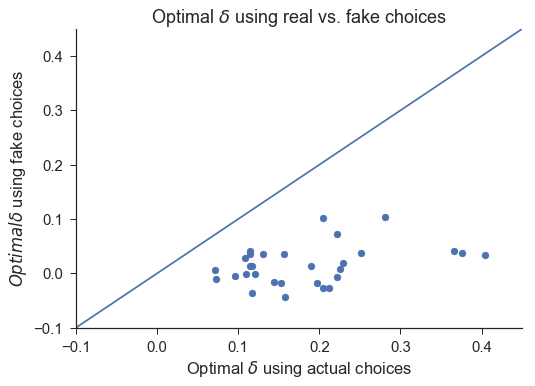

In [40]:
#Plot delta_v from revaluation algorith output using real vs. fake choices
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
plt.scatter(dev_opt['opt_deltav'],dev_opt_fake['opt_deltav'])
plt.xlabel(r'Optimal $\delta$ using actual choices')
plt.ylabel(r'$Optimal \delta$ using fake choices')
plt.title(r'Optimal $\delta$ using real vs. fake choices')
plt.axis([-.1, .45, -.1, .45])
plt.plot( [-.1,.45],[-.1,.45] )
sns.despine()
plt.show()

### Recalculate Revalued Values and Deviance based on Shuffled trial order

In [41]:
# make all trial shuffled dataframes
shuffle_seed=6622

np.random.seed(shuffle_seed)

def shuffledf(i):
    food=pd.read_csv('food.csv',header=0,index_col=0)
    foodshuffle=pd.DataFrame(columns=food.columns)
    for s in food['subjid'].unique():
        foodsub=food[food['subjid']==s]
        foodsubshuffle=foodsub.sample(frac=1).reset_index(drop=True)
        foodshuffle=foodshuffle.append(foodsubshuffle)
    foodshuffle.to_csv('foodshuffle'+str(i)+'.csv')
    return

niter=1000
inputs = range(niter)
num_cores = multiprocessing.cpu_count()
results=Parallel(n_jobs=num_cores)(delayed(shuffledf)(i) for i in inputs)


In [42]:
def do_optim_shuffle(i):
    tlow=-0.6
    thigh=0.6
    food=pd.read_csv('foodshuffle'+str(i)+'.csv',header=0,index_col=0)
    uni_subj=food['subjid'].unique()
    dev_opt=np.ones(len(uni_subj))*np.nan
    for s in range(len(uni_subj)):
        foodsub=food[food['subjid']==uni_subj[s]]
        fn_fit = lambda x: fn_reval(x, foodsub)[0]
        # eval best delta_v:
        xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
        dev_opt[s]=fn_fit(xopt)
    print('Done with iteration '+str(i)+'......')
    return [i, dev_opt.sum()]         

In [43]:
# run 1000 times SLOW
niter=1000
# run revaluation algoritm on shuffled trials
inputs = range(niter)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_shuffle)(i) for i in inputs)
## convert output to dataframe to make life easier
dev_opt_shuffle=pd.DataFrame(results,columns=['iter','opt_dev'])
dev_opt_shuffle.to_csv('dev_opt_shuffle.csv')

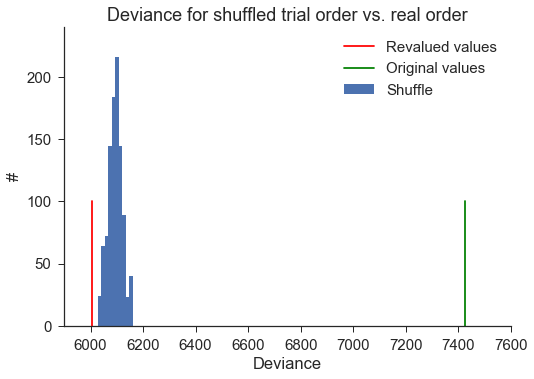

In [44]:
# get deviance for original values actual order
dev_opt_orig=[]
for s in food['subjid'].unique():
    foodsub=food[food['subjid']==s]
    tmp=fn_reval(0,foodsub)[0]
    dev_opt_orig.append(tmp)
    
# deviances for 1000 iterations of shuffled trial order
dev_opt_shuffle=pd.read_csv('dev_opt_shuffle.csv',header=0,index_col=0)
# deviance for revalued values actual order
revaldev=sum(dev_opt['opt_dev'])
# deviance for original values actual order
origdev=sum(dev_opt_orig)

# Plot histogram of deviances for shuffled order
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
plt.hist(dev_opt_shuffle['opt_dev'],label='Shuffle')
plt.xlabel('Deviance')
plt.ylabel('#')
plt.title('Deviance for shuffled trial order vs. real order')
plt.plot([revaldev,revaldev],[0,100],'r-',label='Revalued values')
plt.plot([origdev,origdev],[0,100],'g-',label='Original values')
plt.axis([5900,7600,0,240])
plt.legend()
sns.despine()
plt.show()


### Fit DDM and plot choices and Reaction Times based on Revalued Values

In [45]:
## Plot Choices and RTs based on revised values
foodreval=pd.DataFrame(columns=['RevalueLeft','RevalueRight','deltareval','choseright','subjid'])
for s in food['subjid'].unique():
    dv=dev_opt['opt_deltav'][dev_opt['subjid']==s].values
    subfood=food[food['subjid']==s]
    tmp=fn_reval(dv,subfood)[1]
    #tmp=fn_reval(0,subfood)[1]
    foodreval=foodreval.append(tmp)

foodreval['choseright']=food['choseright'].values
foodreval['deltarevalrnd']=foodreval['deltareval'].round(1)
datafoodreval=np.column_stack([foodreval['deltarevalrnd'],foodreval['RT'],foodreval['choseright']])
datafoodrevalplot=np.column_stack([foodreval['deltarevalrnd'],foodreval['RT'],foodreval['choseright'],
                          foodreval['subjid'],foodreval['deltareval']])

In [46]:
#pickle.dump( foodreval, open( "foodreval.p", "wb" ) )
foodreval = pickle.load(open( "foodreval.p", "rb" ))
#pickle.dump( datafoodrevalplot, open( "datafoodrevalplot.p", "wb" ) )
datafoodrevalplot = pickle.load(open( "datafoodrevalplot.p", "rb" ))

In [47]:
# fit to reval
[thetafoodreval, foodrevalfopt]=fitData(datafoodreval, dt=.0005)
#[thetafoodreval, foodrevalfopt]=[[1.182697838,1.30983515,0.000948348,0.419617397,0.483438474,0.097808889,
                                  -0.058215409,0,0.771627663],53258.97961]

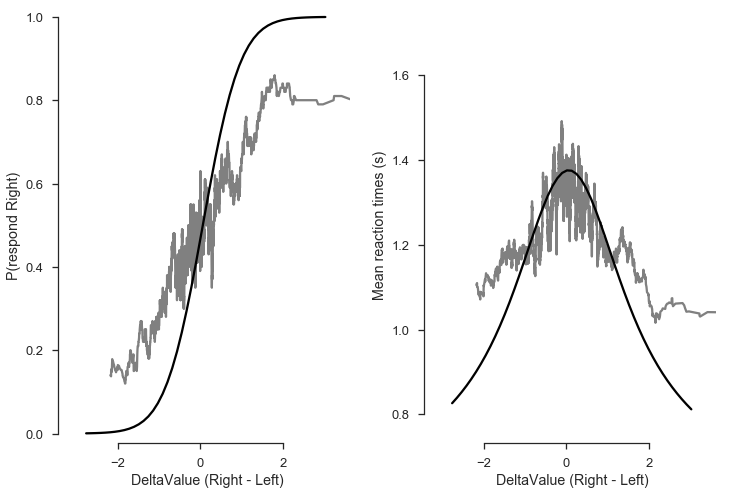

In [48]:
sns.set_style('ticks')
sns.set_context('talk')
plotFoodDataWithFit(datafoodrevalplot,thetafoodreval, dt=.0005)

### Plot all trials per participants of food ReVal with fits

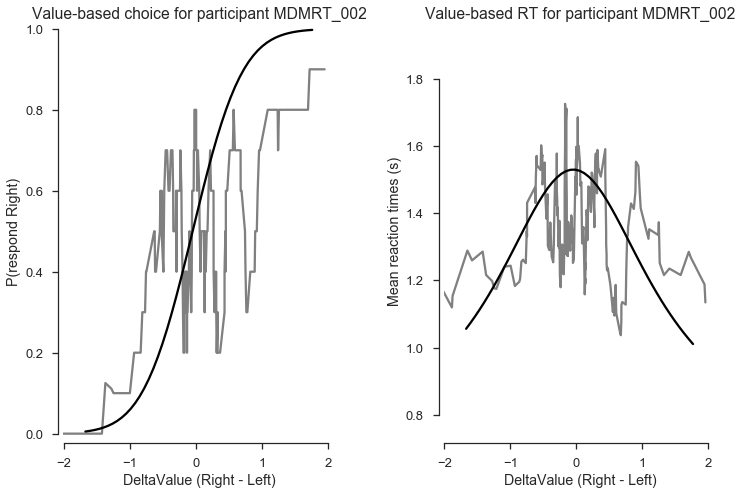

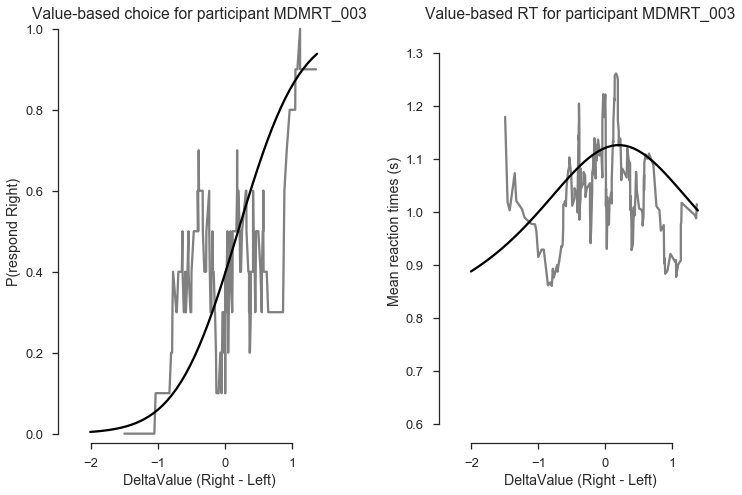

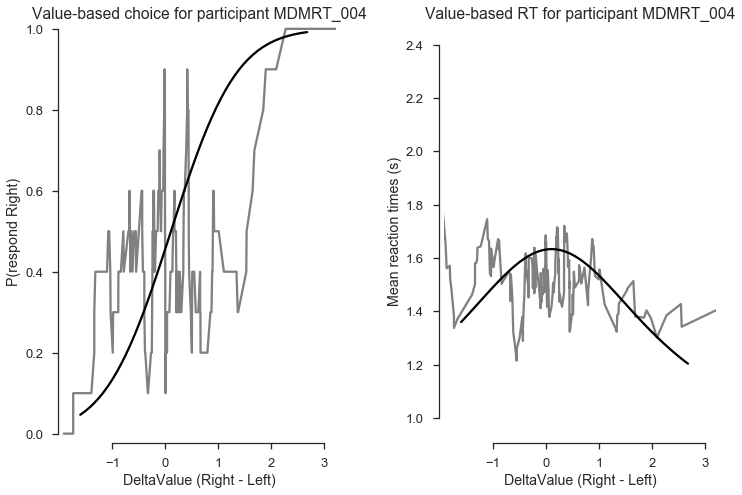

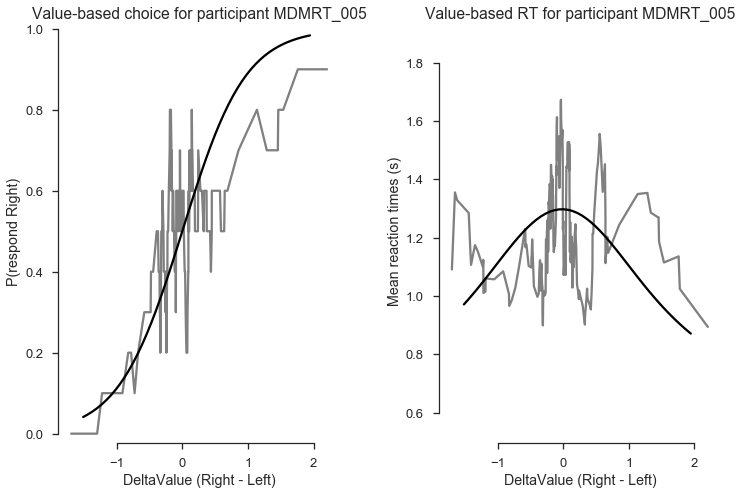

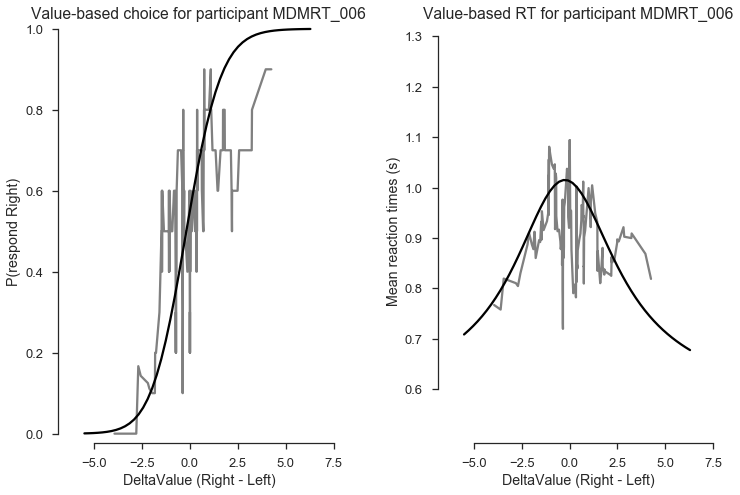

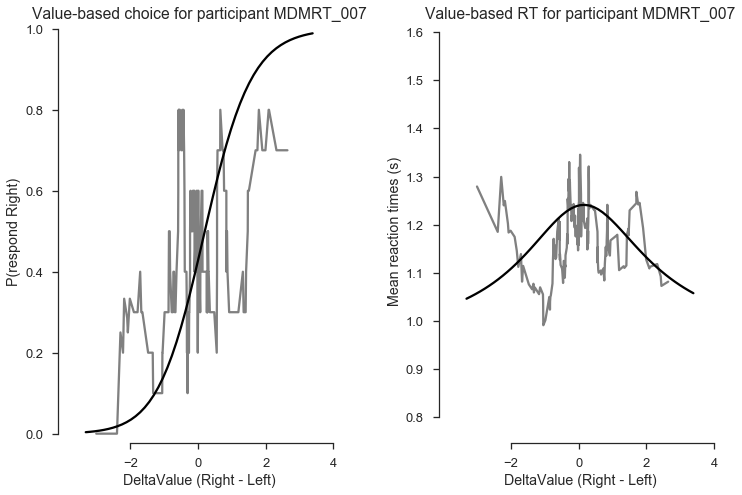

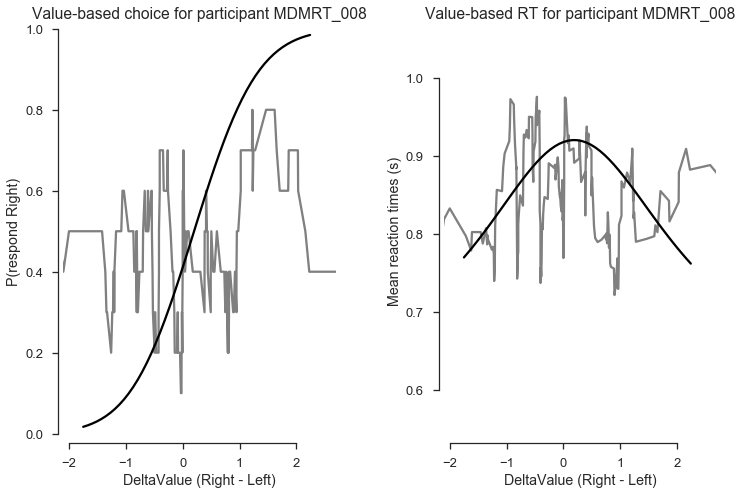

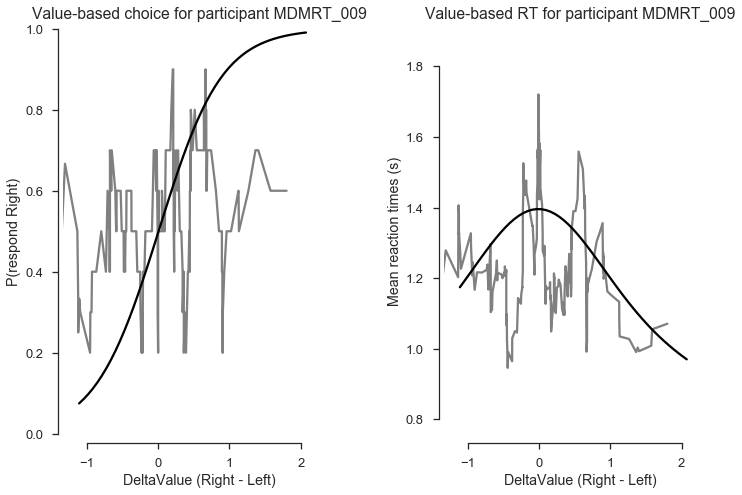

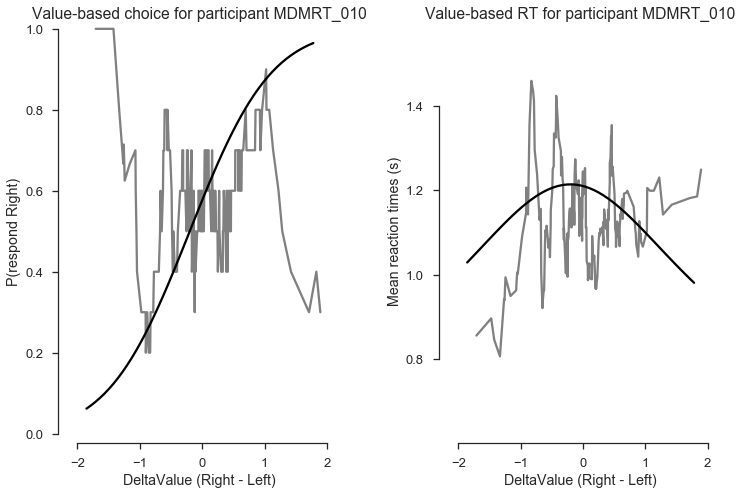

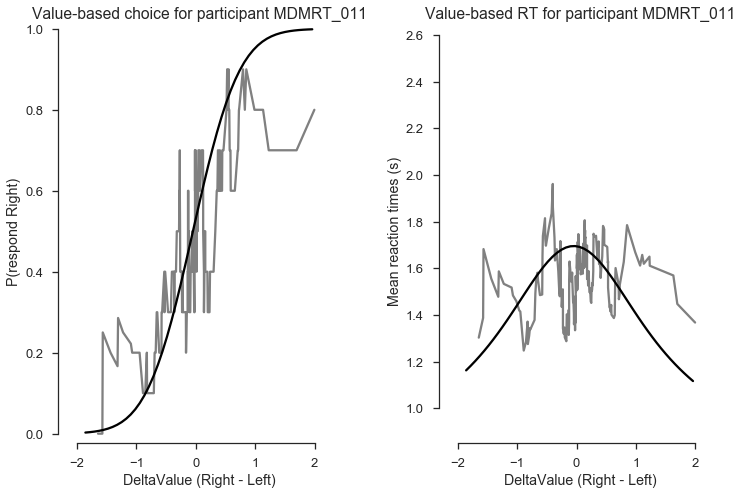

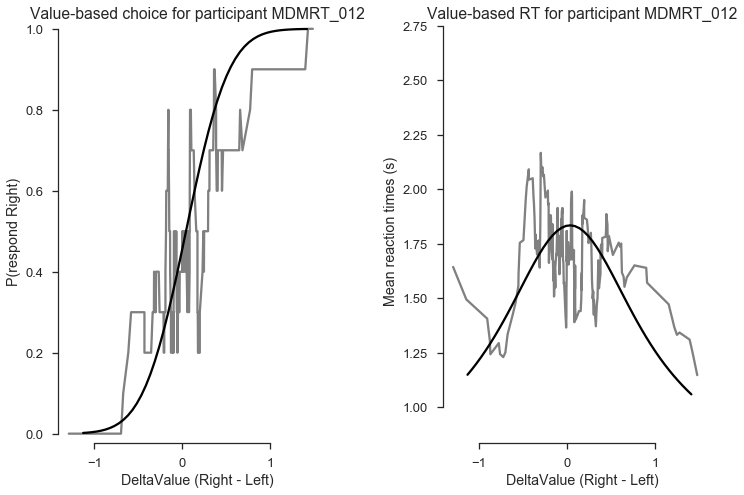

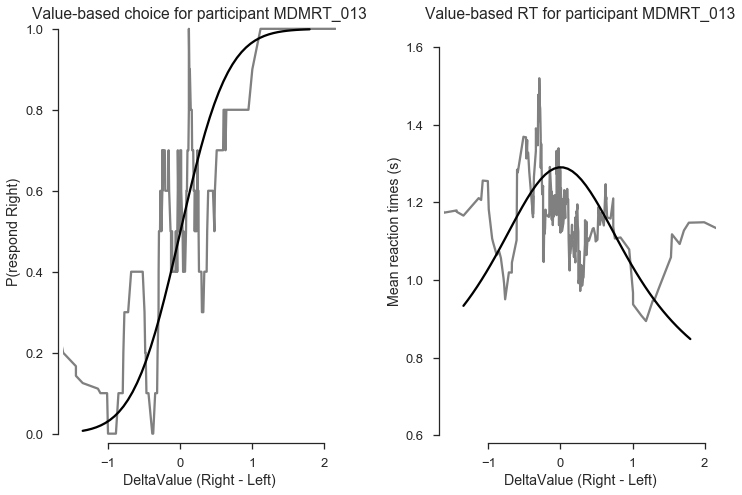

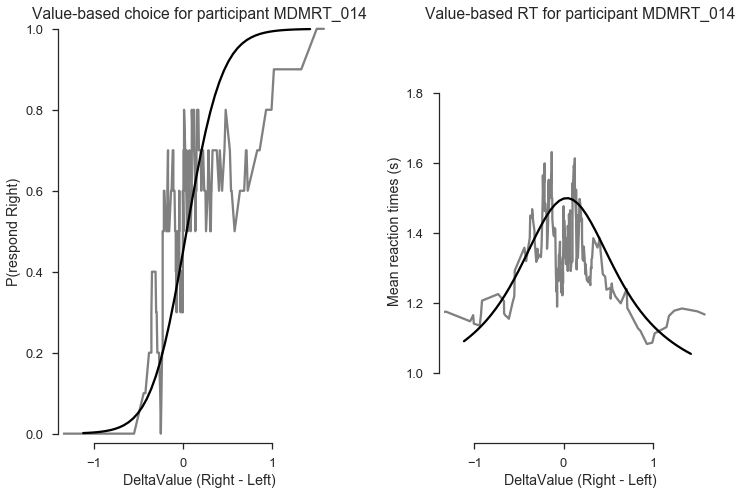

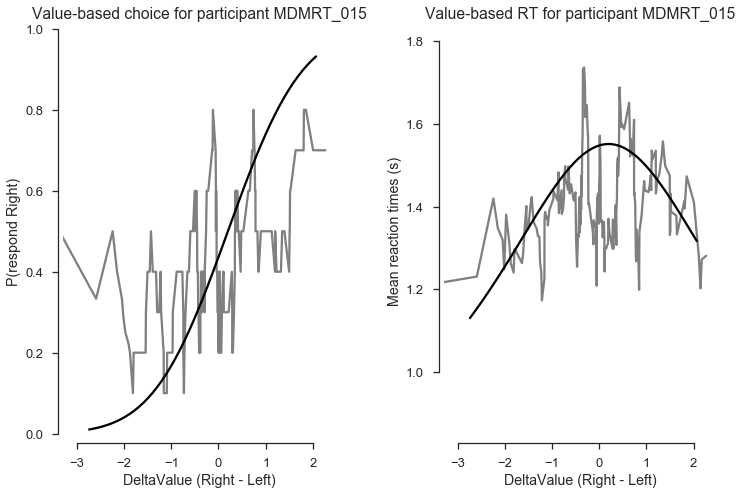

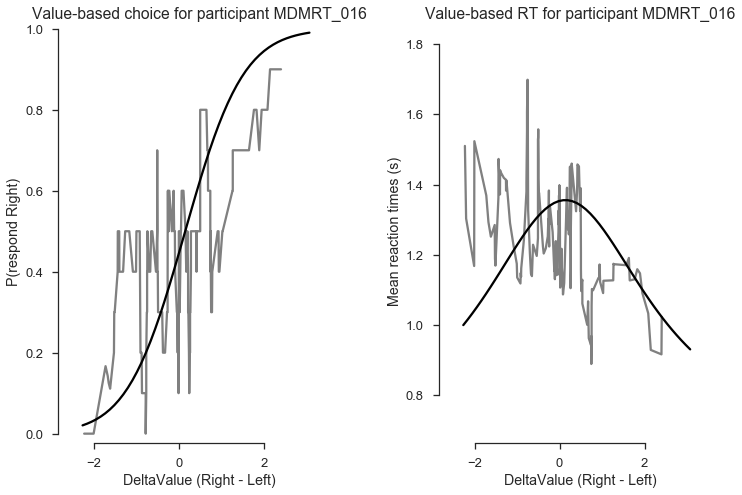

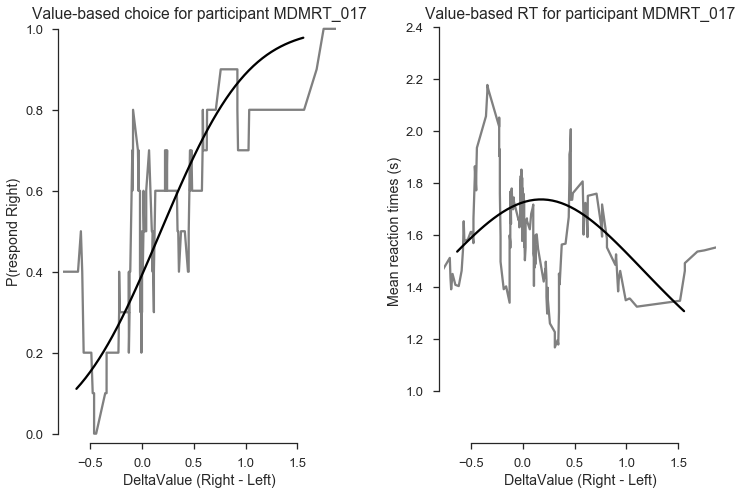

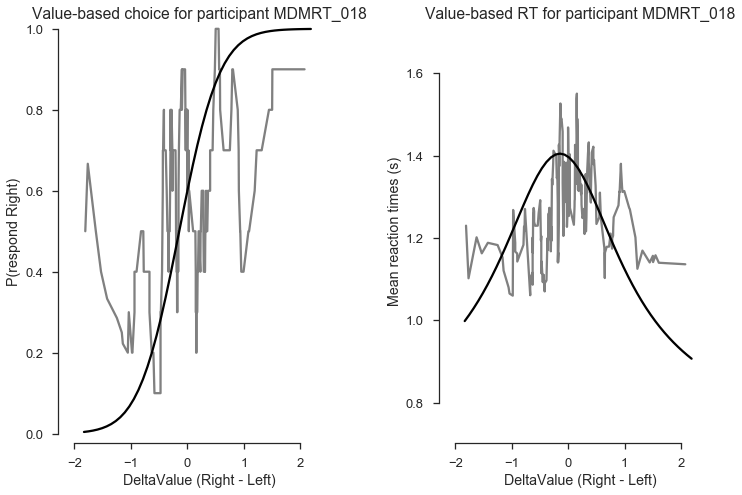

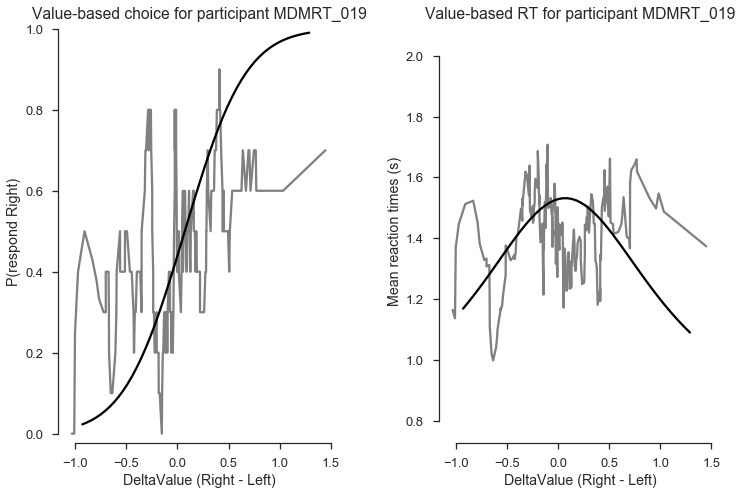

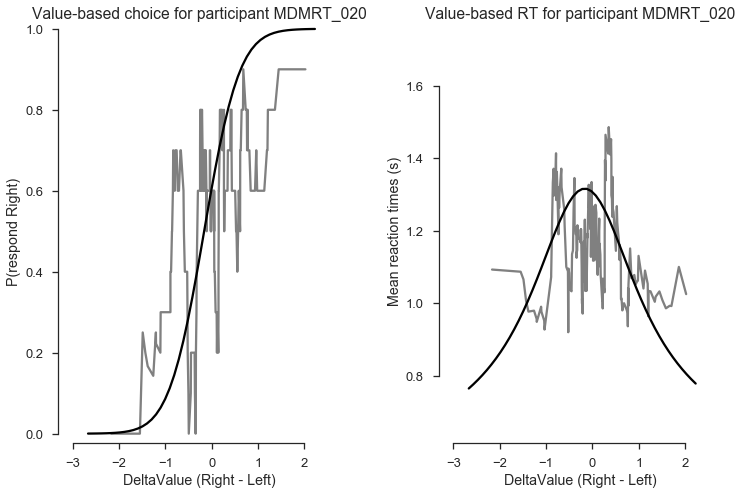

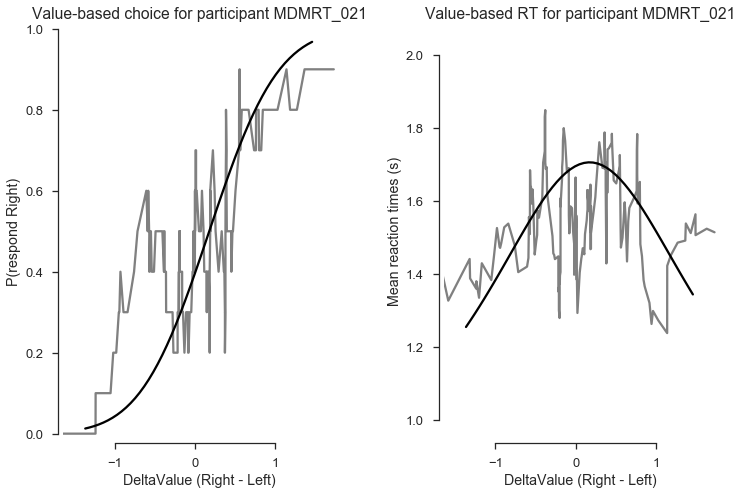

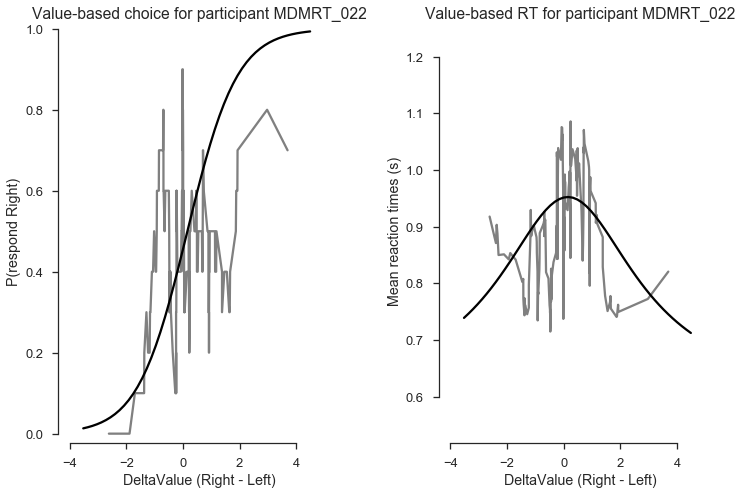

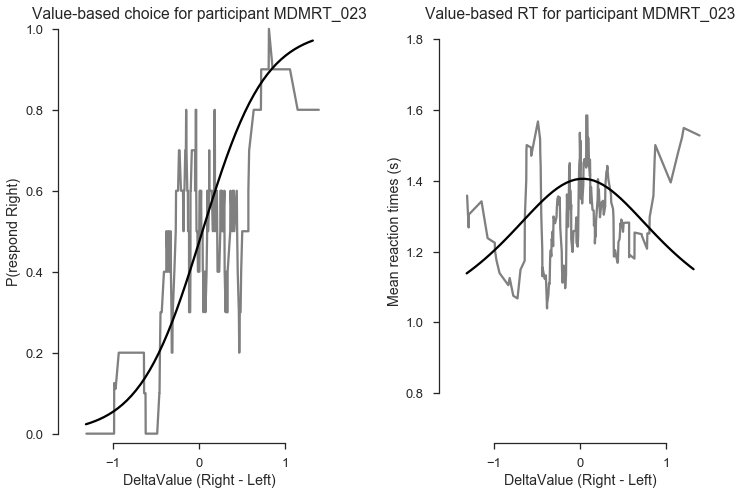

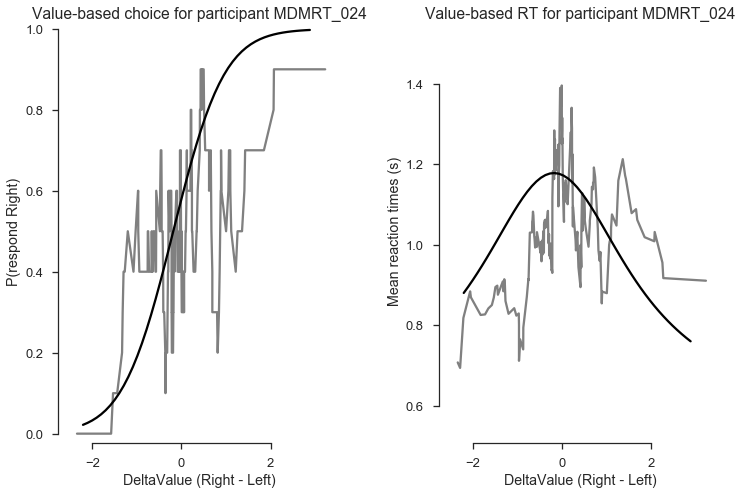

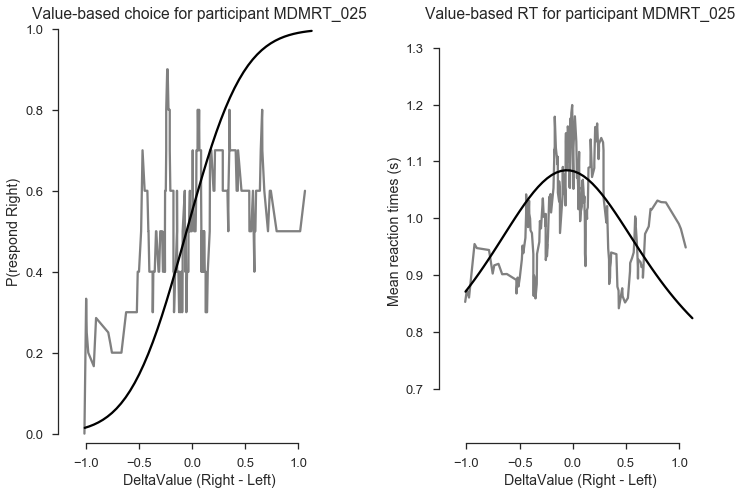

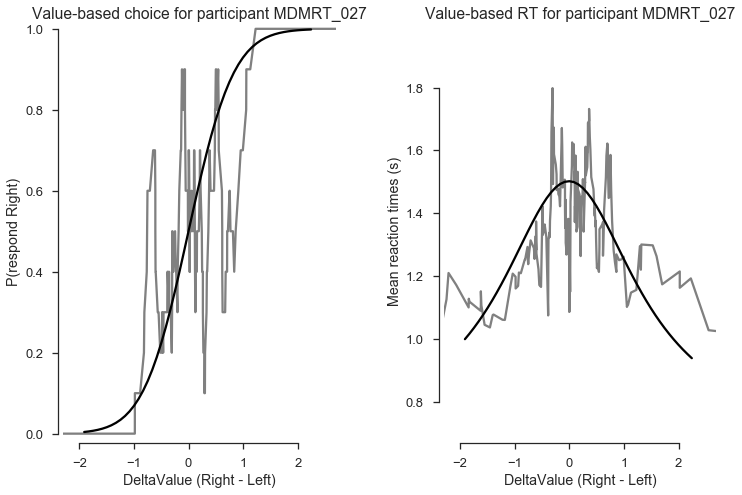

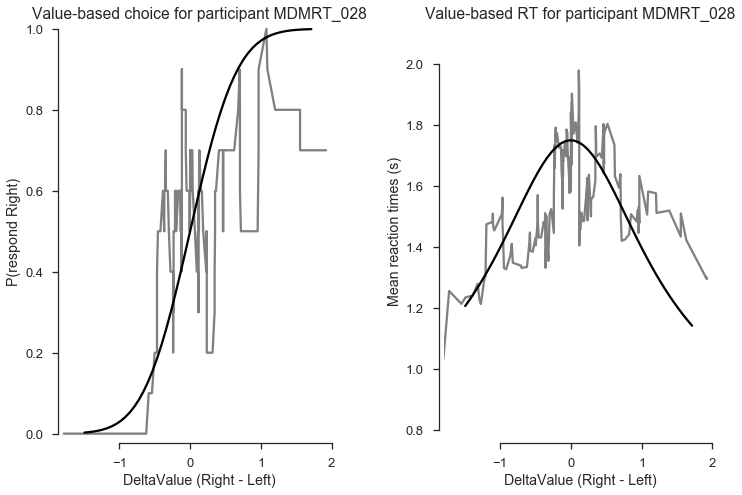

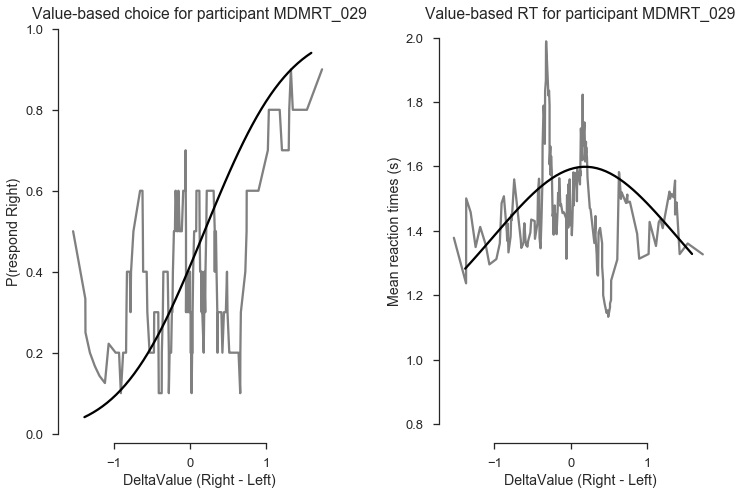

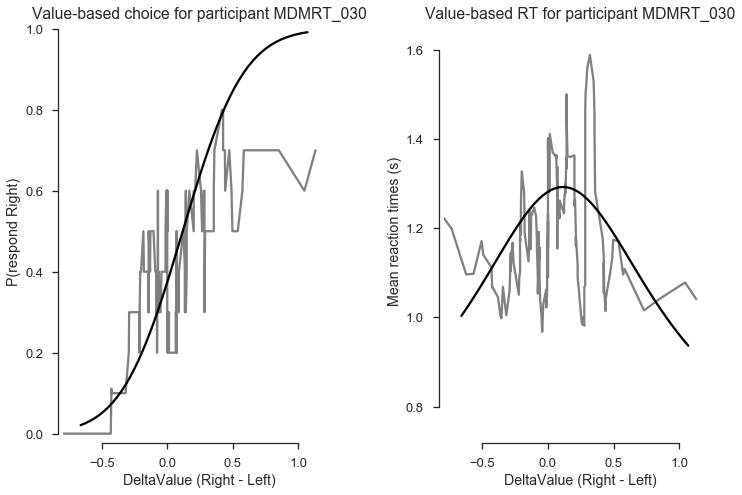

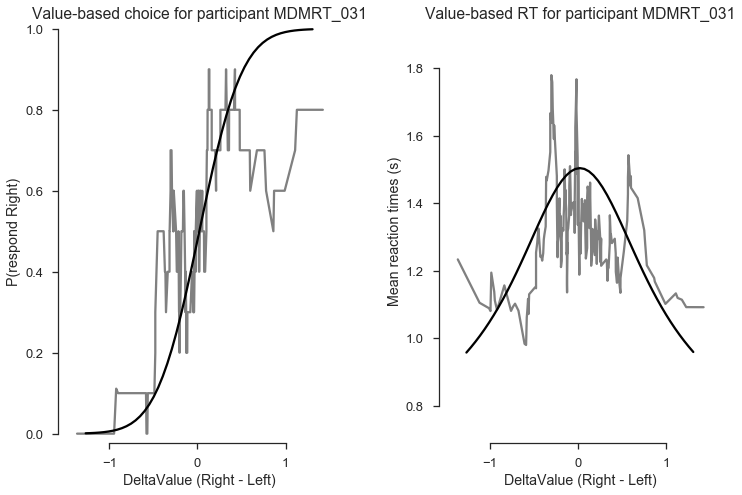

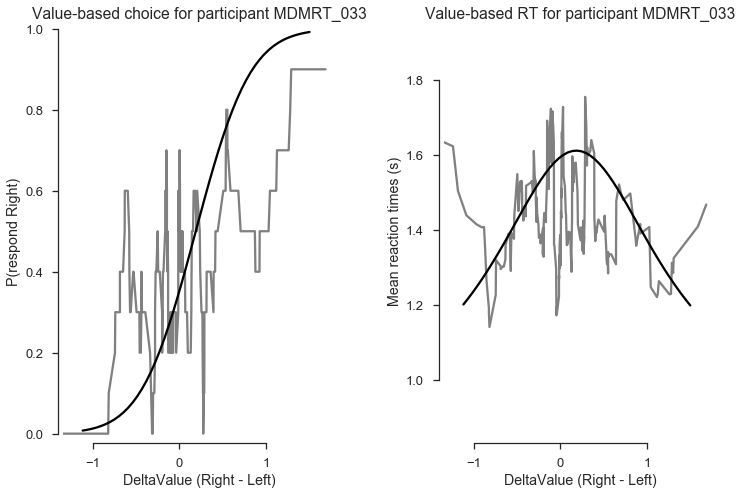

In [49]:
thetafoodreval=pd.read_csv('/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Manuscript/Figures/thetas/foodreval_thetas_persub.csv')
for s in foodreval.subjid.unique():
    foodrevalsub=foodreval.loc[foodreval['subjid']==s]
    datafoodrevalsub=np.column_stack([foodrevalsub['deltarevalrnd'],foodrevalsub['RT'],foodrevalsub['choseright'],
                                      foodrevalsub['deltareval']])
    #[thetafoodrevalsub,foodrevalsubfopt]=fitData(foodrevalsub)    
    thetafoodrevalall=thetafoodreval[thetafoodreval.subjid==s]
    thetafoodrevalsub=thetafoodrevalall.iloc[0].tolist()[2:-1]
    # Plot data with fits
    plotFoodsubDataWithFit(datafoodrevalsub, thetafoodrevalsub, s, dt=.005)
    outputfit(datafoodrevalsub, thetafoodrevalsub, s, 'foodreval', dt=.0005)

In [50]:
### Map of effect of ReValued Value on BOLD

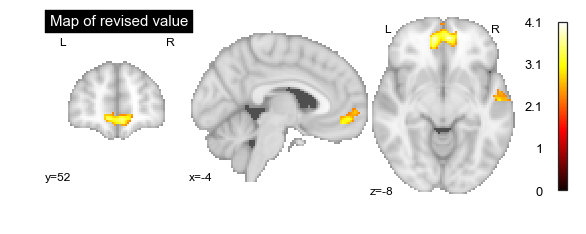

In [51]:
## Map of revised value in a model that also includes the original BDM value
revisedvalue_map=nilearn.image.load_img(imgpath +'/group/model038/task001/cope006.gfeat/cope1.feat/thresh_zstat1.nii.gz')
nilearn.plotting.plot_stat_map(revisedvalue_map,cut_coords=[-4,52,-8],draw_cross=False, 
                               title="Map of revised value")
plt.show()

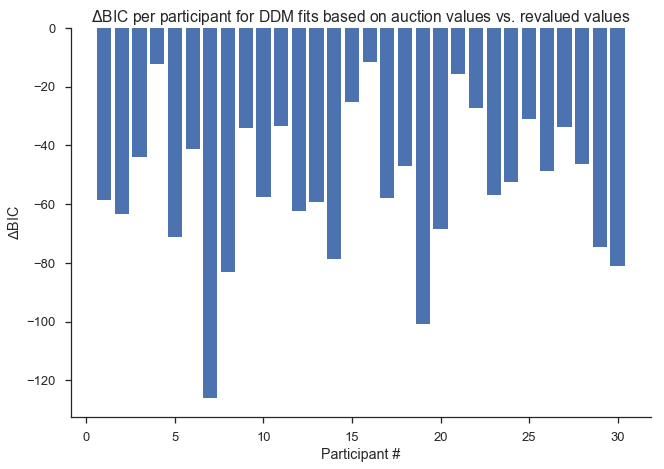

In [53]:
def calculateBIC(nll,n,k):
    bic=np.log(n)*k+2*nll
    return bic

thetafood=pd.read_csv('/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Manuscript/Figures/thetas/food_thetas_persub.csv')
thetafoodreval=pd.read_csv('/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Manuscript/Figures/thetas/foodreval_thetas_persub.csv')


foodreval = pickle.load(open( "foodreval.p", "rb" ))
food = pickle.load(open( "food.p", "rb" ))

k1=8 # 8 params for food
k2=9 # 9 params for foodreval
bic=[]
for s in food.subjid.unique():
    foodsub=food.loc[food['subjid']==s]
    n1=len(foodsub.subjid)
    foodrevalsub=foodreval.loc[foodreval['subjid']==s]
    n2=len(foodrevalsub.subjid)
    
    thetafoodall=thetafood[thetafood.subjid==s]
    nll1=thetafoodall.NLL
    thetafoodrevalall=thetafoodreval[thetafoodreval.subjid==s]
    nll2=thetafoodrevalall.NLL
    
    bic1=calculateBIC(nll1,n1,k1)
    bic2=calculateBIC(nll2,n2,k2)
    
    bic.append(float(bic2)-float(bic1))

# Plot histogram of deviances for shuffled order
#sns.set(font_scale=1.5)
#sns.set_style("white")
#sns.set_style("ticks")
plt.figure()
plt.bar(range(1,31),bic)
plt.xlabel('Participant #')
plt.ylabel(r'$\Delta$BIC')
plt.title(r'$\Delta$BIC per participant for DDM fits based on auction values vs. revalued values')
sns.despine()
plt.show()
